# Sommaire :
 - <a href="#C1">Importation des données</a>
 
**Partie 2 : Nettoyez un jeu de données**
 - <a href="#C2">Nettoyez votre jeu de données</a>
 
**Partie 3 : Représentez vos variables**
 - <a href="#C3">Représentez la distribution empirique d'une variable</a>
 - <a href="#C4">Présentez une variable sous forme de tableau</a>
 - <a href="#C5">Découvrez les mesures de tendance centrale</a>
 - <a href="#C6">Comprenez les mesures de dispersion</a>
 - <a href="#C7">Appréhendez les mesures de forme</a>
 - <a href="#C8">Familiarisez-vous avec les mesures de concentration</a>
 
**Partie 4 : Réalisez une analyse bivariée**
 - <a href="#C9">Analysez la corrélation entre deux variables quantitatives</a>
 - <a href="#C10">Analysez deux variables quantitatives par régression linéaire</a>
 - <a href="#C11">Analysez une variable quantitative et une qualitative par ANOVA</a>
 - <a href="#C12">Analysez deux variables qualitatives avec le Chi-2</a>

# <a name="C1">Importation des données</a>

Les données que nous allons utiliser tout au long de ce cours se trouvent dans le même dossier compressé où vous avez trouvé le présent notebook. Comme annoncé en préambule, c'est un fichier contenant les relevés bancaires (fictives) d'un individu. Importons dans un premier temps l'ensemble des librairies qui vont nous servir durant l'entièreté de ce cours :

In [1]:
# si l'un des packages n'est pas installé :
# install.packages("ggplot2")
# install.packages("moments")

library(moments)
library("ggplot2")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Nous pouvons à présent charger le jeu de données, dans un dataframe que nous nommerons ici `data`. Nous affichons ensuite les 5 premières lignes.

In [2]:
data = read.csv('operations.csv',
                stringsAsFactors = FALSE, # pour éviter de travailler avec des Factors et faciliter les traitements
                fileEncoding = "UTF-8", # spécifier l'encodage du fichier
                na.strings=c("","NA"))
head(data)

date_operation,libelle,montant,solde_avt_ope,categ
2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE
2023-04-03,CARTE XX XX XX XX,-14.39,2097.61,AUTRE


In [3]:
dim(data)

[1] 309   5

Comme vous pouvez le voir via la commande ci dessus, nous avons 309 transactions, renseignées sur 5 variables différentes. Nous avons notamment : 
- date_operation : date de l'opération
- libelle : libellé de l'opération
- montant : montant de l'opération
- solde_avt_ope : solde du compte avant l'opération considérée
- categ : catégorie d'achat

<font color='darkred'>*vous aurez probablement moins d'informations sur vos propres relevés bancaires. Nous avons réalisé quelques lignes de codes en amont pour ajouter la catégorie d'achat*</font>

# <a name="C2">P2C3 - Nettoyez votre jeu de données</a>

Il est à présent temps de mettre en pratique tout ce que nous avons vu sur notre jeu de données de transactions bancaires. Plusieurs **erreurs** se sont glissées dans ce jeu de données. Votre mission, si toutefois vous l'acceptez, va être de les **trouver** et de **proposer des solutions** adéquates pour les gérer.

### 1. Erreurs de type

Le premier reflexe devrait être de vérifier que les variables ont bien été importées dans le bon type :

In [4]:
str(data)

'data.frame':	309 obs. of  5 variables:
 $ date_operation: chr  "2023-03-31" "2023-04-03" "2023-04-03" "2023-04-03" ...
 $ libelle       : chr  "DON XX XX XX XX XX XX XX" "CARTE XX XX RAPT XX" "CARTE XX XX RAPT XX" "VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX" ...
 $ montant       : num  -1.44 -24 -73 676 4.8 ...
 $ solde_avt_ope : num  1515 1514 1490 1417 2093 ...
 $ categ         : chr  "AUTRE" "TRANSPORT" "TRANSPORT" "AUTRE" ...


La seule chose qui semble être problématique est la variable date qui n'est pas considérée comme une date. On peut corriger cela facilement via la fonction `to_datetime` de pandas :

In [5]:
data$date_operation = as.Date(data$date_operation , "%Y-%m-%d")

Sinon, tout semble en ordre

### 2. Valeurs manquantes

On va ensuite vérifier si notre jeu de données contient des valeurs manquantes :

In [6]:
sapply(data, function(y) sum(is.na(y)))

date_operation        libelle        montant  solde_avt_ope          categ 
             0              0              2              0              1

In [7]:
# pour afficher uniquement les variables qui ont des valeurs manquantes
nb_na = sapply(data, function(y) sum(is.na(y)))
nb_na[nb_na>0]

montant   categ 
      2       1

On observe que notre jeu de données contient 3 valeurs manquantes. Regardons les plus en détails :

In [8]:
data[is.na(data$montant),]

,date_operation,libelle,montant,solde_avt_ope,categ
108,2023-06-12,CARTE XX XX LES ANCIENS ROBINSON XX,NA,4667.19,COURSES
270,2023-09-11,CARTE XX XX XX XX,NA,3401.93,AUTRE


Ici, il reste relativement simple de remplacer les valeurs manquantes : en effet, les transactions étant organisées par ordre chronologique, on peut à partir du solde de l'opération suivante déduire le montant qui a été débité pour chacune des ces opérations.

Le montant manquant correspond donc au solde de l'opération suivante, moins le solde de l'opération concernée. Voilà comment faire cela pour nos lignes concernées :

In [9]:
# on stocke les index des valeurs manquantes au sein de notre dataframe initial
data_na = as.numeric(rownames(data[is.na(data$montant),]))


for(i in 1:length(data_na)){
    # pour chaque ligne de mon df contenant un NA, on récupère l'index correspondant
    index = data_na[i] 
    # calcul du montant à partir des soldes précédents et actuels 
    data$montant[index] = data$solde_avt_ope[index+1] - data$solde_avt_ope[index]
}

A présent regardons la categorie manquante :

In [10]:
data[is.na(data$categ),]

,date_operation,libelle,montant,solde_avt_ope,categ
157,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NA


Par manque d'informations, on devrait supprimer ici la ligne correspondante. Mais regardons si nous ne pouvons pas trouver la catégorie à partir des autres informations, notamment le libellé :

In [11]:
data[data$libelle == 'PRELEVEMENT XX TELEPHONE XX XX',]

,date_operation,libelle,montant,solde_avt_ope,categ
9,2023-04-05,PRELEVEMENT XX TELEPHONE XX XX,-7.02,2056.02,FACTURE TELEPHONE
63,2023-05-09,PRELEVEMENT XX TELEPHONE XX XX,-7.02,4090.10,FACTURE TELEPHONE
103,2023-06-07,PRELEVEMENT XX TELEPHONE XX XX,-6.38,4688.91,FACTURE TELEPHONE
157,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NA
205,2023-08-07,PRELEVEMENT XX TELEPHONE XX XX,-7.46,3751.73,FACTURE TELEPHONE
261,2023-09-05,PRELEVEMENT XX TELEPHONE XX XX,-6.38,3453.96,FACTURE TELEPHONE
309,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2413.58,FACTURE TELEPHONE


On déduit assez facilement que la catégorie manquante ici est : FACTURE TELEPHONE

In [12]:
data[is.na(data$categ),'categ'] = 'FACTURE TELEPHONE'

### 3. Doublons 

Regardons à présent si certaines transactions sont apparues en doublons. Pour cela, on se concentrera sur des informations qui ne peuvent normalement pas être doublés, soit : la date, le libelle, le montant et le solde avant opération. Sur ces 4 variables, il n'est normalement pas possible d'avoir deux transactions identiques :

In [13]:
col = c('date_operation', 'libelle', 'montant', 'solde_avt_ope')
data[duplicated(data[col]) | duplicated(data[col], fromLast=TRUE),]

,date_operation,libelle,montant,solde_avt_ope,categ
44,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES
45,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES


On a ici une opération qui est complètement en double. Il suffit donc de supprimer l'une des deux via le drop_duplicate

In [14]:
data = data[!duplicated(data[col]),]

### 4. Détection d'outliers :

Un `summary` peut potentiellement nous aider dans un premier temps :

In [15]:
summary(data)

 date_operation         libelle             montant           solde_avt_ope 
 Min.   :2023-03-31   Length:308         Min.   :-15000.000   Min.   :1417  
 1st Qu.:2023-05-21   Class :character   1st Qu.:   -20.448   1st Qu.:3011  
 Median :2023-07-05   Mode  :character   Median :    -9.600   Median :3452  
 Mean   :2023-07-05                      Mean   :   -45.782   Mean   :3395  
 3rd Qu.:2023-08-21                      3rd Qu.:    -2.715   3rd Qu.:3787  
 Max.   :2023-10-06                      Max.   :  1071.600   Max.   :4709  
    categ          
 Length:308        
 Class :character  
 Mode  :character  
                   
                   
                   

Une bonne première approche en attendant d'avoir des outils plus adéquats, est de regarder le maximum et le minimum. Cela donne généralement un premier apperçu de ce qui pourrait clocher à ce niveau. Ici on voit un minimum de montant de -15 000 (ce qui correspondrait à un débit de -15000). Cela semble assez étonnant, d'autant que le solde ne semble pas descendre en conséquence à aucun moment (le max est 4700 et le minimum 1416). Vérifions les soldes autour de cette transaction :

In [16]:
i = as.numeric(rownames(data[data$montant==-15000,])) # récupération de l'index de la transaction à -15000

data[(i-2):i,] # on regarde la transaction précédente et la suivante

,date_operation,libelle,montant,solde_avt_ope,categ
199,2023-08-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,3121.35,AUTRE
200,2023-08-03,CARTE XX XX XX XX,-15000.00,3797.35,AUTRE
201,2023-08-03,CARTE XX XX L'EPICERIE DEMBAS XX XX,-10.51,3782.96,AUTRE


Il y a en effet une grosse incohérence. Les soldes nous indique une opération de -14.39 et non de -15000. Il y a en effet une valeur abérrante ici ! Remplaçons donc là pour sa valeur initiale :

In [17]:
data[data$montant==-15000, 'montant'] = -14.39

Le jeu de données semble à présent propre, on peut avancer sur la partie analyse.

# <a name="C3"> P3C1 - Représentez la distribution empirique d'une variable</a>

**1. variables qualitatives**

Voici 2 représentations possibles de la distribution de la variable categ :

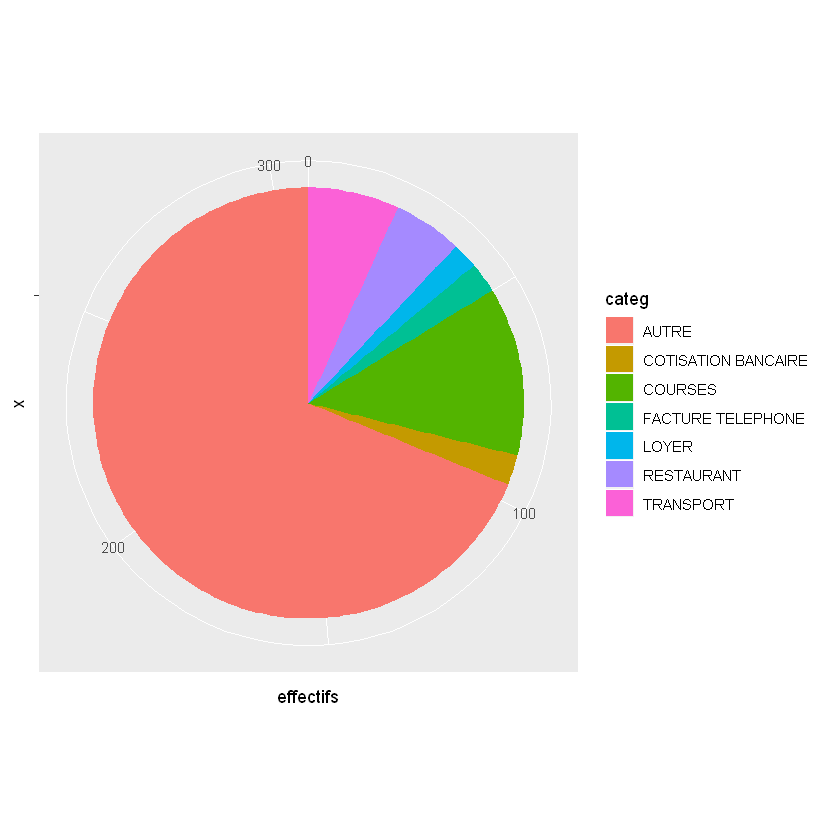

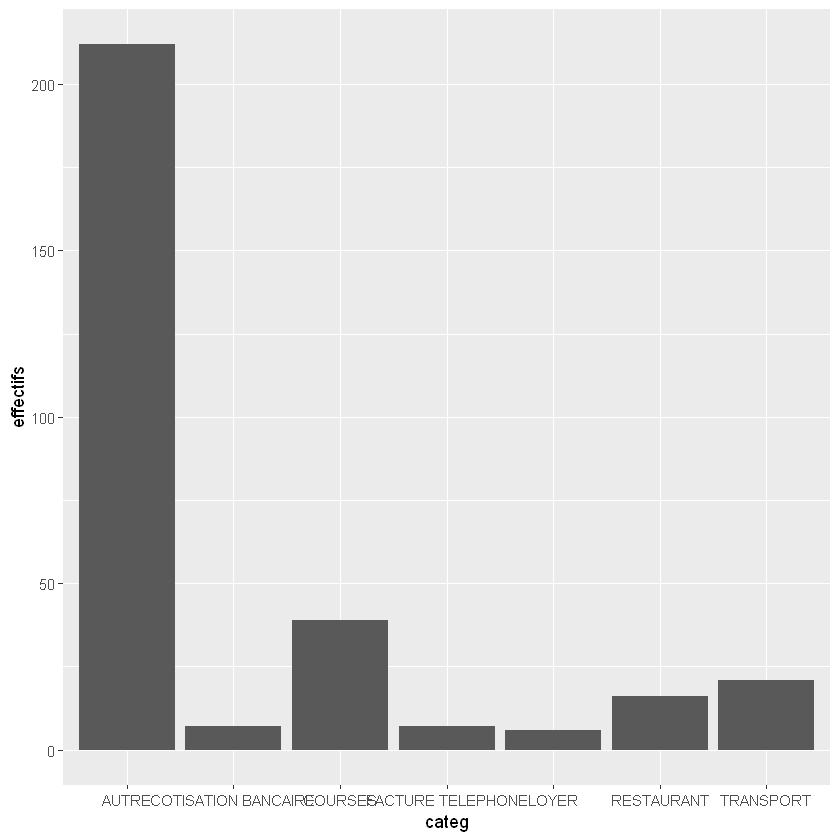

In [18]:
# VARIABLE QUALITATIVE
value_counts = as.data.frame(table(data$categ))
colnames(value_counts) = c("categ","effectifs")

# Diagramme en secteurs
ggplot(value_counts, aes("",effectifs,fill=categ)) +
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y")

# Diagramme en tuyaux d'orgues
ggplot(value_counts, aes(categ,effectifs)) + geom_bar(stat = "identity")

À gauche, vous avez le diagramme en secteurs, plus connu sous le nom de diagramme en camembert. Si les francophones y voient un camembert (fleuron de la gastronomie française), les anglophones y voient plutôt une tarte, et l'appellent donc **pie chart**. Ici, l'angle de chaque secteur est proportionnel à l'effectif de chaque modalité.

À droite, c'est le diagramme en tuyaux d'orgue, appelé en anglais **bar chart**. La hauteur des tuyaux est égale à l'effectif de chaque modalité, ou bien (au choix) égale à la fréquence de chaque modalité, comme c'est le cas ici.

**2. Variables quantitatives**

Pour les **variables discrètes**, on les représente par un équivalent du diagramme en tuyaux d'orgue : **le diagramme en bâtons**. Cependant, avec les variables qualitatives, on pouvait placer les tuyaux un peu n'importe où sur l'axe horizontal. Mais avec une variable quantitative, on est contraint à placer précisément les bâtons sur l'axe horizontal. Comme on doit être précis, on préfère que les bâtons soient très fins. 

Pour représenter cela, nous allons créer une variable `quart_mois` pouvant prendre les valeurs 1, 2, 3 ou 4, et indiquant l'avancée dans le mois (1 : début, ..., 4 : fin de mois) :

In [19]:
data["jour"] = apply(data["date_operation"], 1, FUN=function(d) as.integer(format(as.Date(d),"%d"))) 
data["quart_mois"] = apply(data["jour"], 1, function(jour) as.integer((jour-1)*4/31)+1 )
data["jour"] <- NULL

On peut à présent représenter sa distribution :

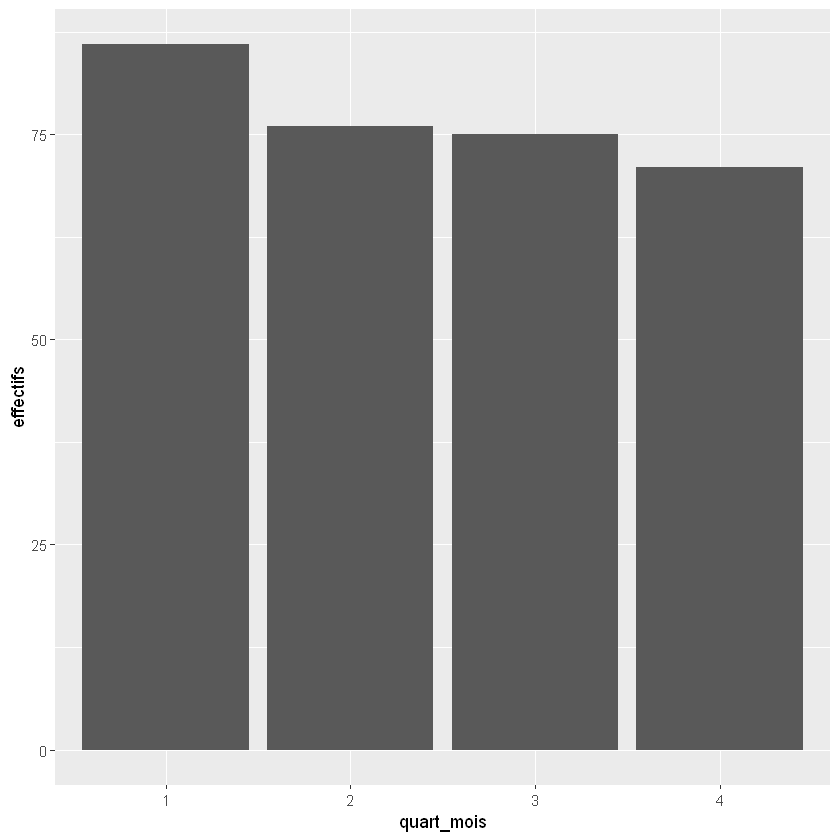

In [20]:
# Diagramme en bâtons
value_counts = as.data.frame(table(data$quart_mois))
colnames(value_counts) = c("quart_mois","effectifs")
ggplot(value_counts, aes(quart_mois,effectifs)) + geom_bar(stat = "identity")

Pour les variables **continues**, on utilise l'histogramme, dans lequel les valeurs sont agrégées. Ici, comme on représente des classes (ou des intervalles, si vous préférez), on n'utilise plus de fins bâtons, mais des rectangles dont la largeur correspond à la largeur de la classe.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


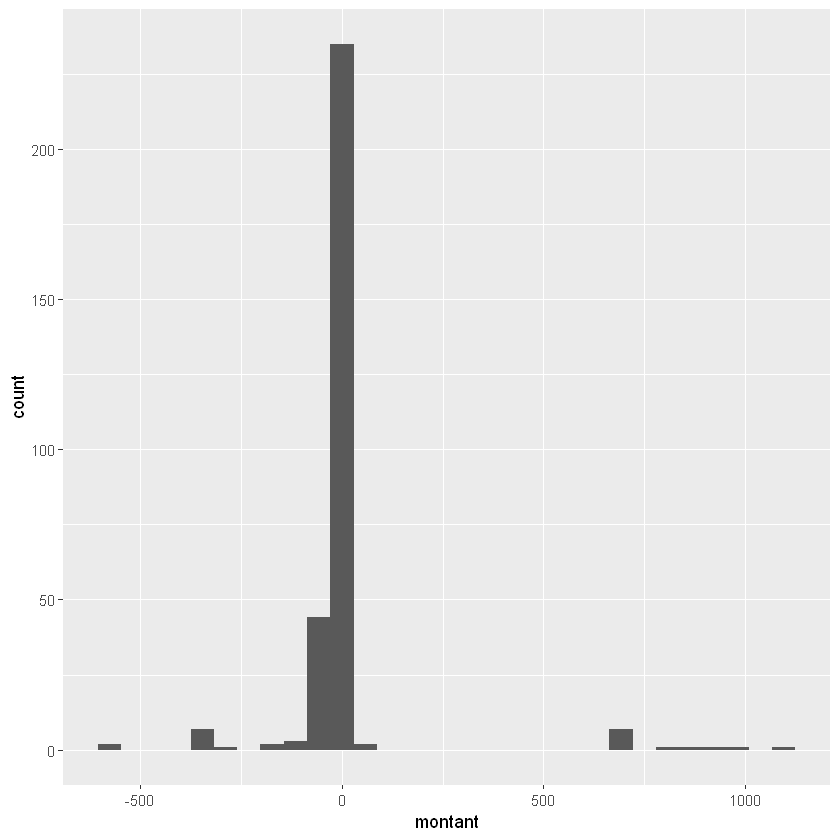

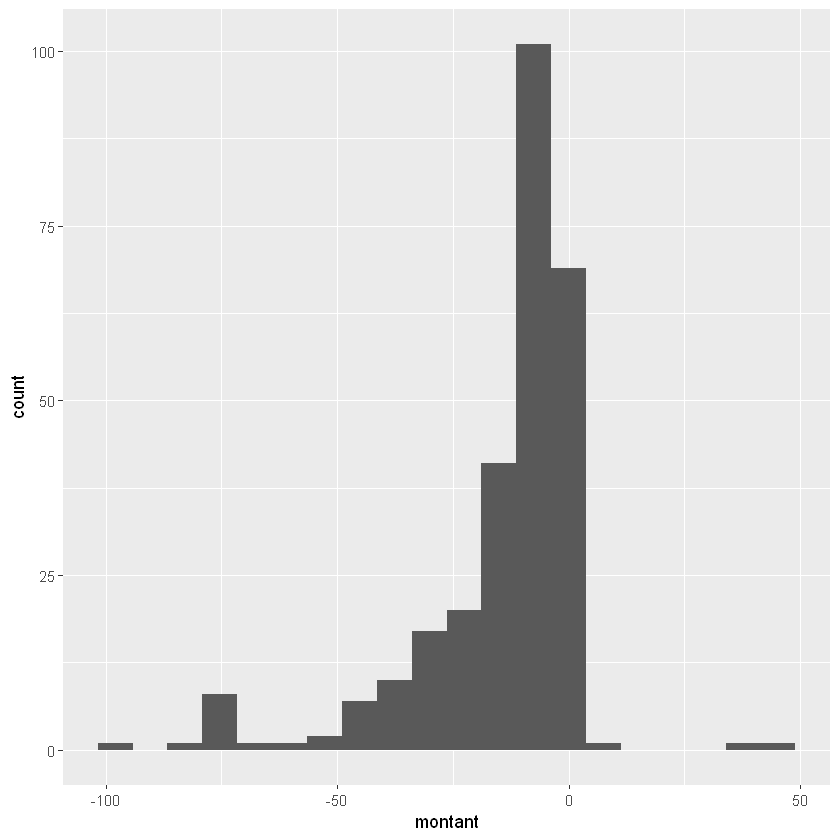

In [21]:
# Histogramme
ggplot(data, aes(montant)) + geom_histogram()

# Histogramme plus beau
subset = data[abs(data$montant) < 100,]
ggplot(subset, aes(montant)) + geom_histogram(bins=20)

# <a name="C4"> P3C2 - Présentez une variable sous forme de tableau</a>

Voici le code qui a généré le tableau récapitulatif de la variable quart_mois.

In [22]:
tab = as.data.frame(table(data$quart_mois))
colnames(tab) = c("quart_mois","n")
tab["f"] = tab["n"] / nrow(data)

tab

quart_mois,n,f
1,86,0.2792208
2,76,0.2467532
3,75,0.2435065
4,71,0.2305195


Pour calculer les fréquences cumulées, il suffit de 2 lignes en plus. L'une trie les valeurs, et l'autre calcule la somme cumulée des fréquences :

In [23]:
tab = tab[order(tab$quart_mois),]
tab["F"] = cumsum(tab["f"])
tab

quart_mois,n,f,F
1,86,0.2792208,0.2792208
2,76,0.2467532,0.5259740
3,75,0.2435065,0.7694805
4,71,0.2305195,1.0000000


# <a name="C5"> P3C4 - Découvrez les mesures de tendance centrale</a>

En R, le calcul du mode est un peu plus complexe qu'en Python. Il va falloir créer une fonction intermédiaire qui va nous permettre de calculer le mode :

In [24]:
mode = function(v) {
   uniqv = unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

Qu'on peut utiliser simplement avec :

In [25]:
mode(data$montant)

[1] -1.6

Voici comment calculer la moyenne des montants dépensés :

In [26]:
mean(data$montant)

[1] 2.872565

Voilà comment calculer la médiane des montants :

In [27]:
median(data$montant)

[1] -9.6

Analysons un peu plus en détail notre variable montant.

Les montants des opérations sont très hétérogènes : il y a des dépenses (à montant négatif) parfois grosses (les loyers, par exemple), souvent petites (courses, téléphone, etc.), et il y a des rentrées d'argent (à montant positif), peu fréquentes mais grosses. Difficile donc d'interpréter la moyenne (très sensible aux valeurs atypiques) qui vaut ici 2,87 €.

On a le même problème pour la médiane qui vaut -9,6 €. Le fait qu'elle soit négative nous indique cependant qu'il y a plus de dépenses que d'entrées d'argent. Par contre, le mode nous indique que la plupart des opérations tournent autour de -1,6 €. Ici, les 3 mesures sont très éloignées les unes des autres.

Pour avoir des montants d'opérations plus homogènes, il serait intéressant de calculer ces mesures pour chaque catégorie d'opération : les montants devraient être moins éparpillés au sein d'une catégorie puisque les opérations sont de même nature. Je vous laisse le faire en Python. Vous pouvez réaliser cela via une boucle `for`, qui itérera sur chacune des catégories. Ne vous arrêtez cependant pas uniquement au code, essayez d'en tirer une dimension analytique : quelle interprétation pouvez-vous faire des résultats ?

[1] "--------------------"
[1] "AUTRE"
[1] "mod"
[1] -1.6
[1] "moy"
[1] 23.43321
[1] "med"
[1] -8.31
[1] "--------------------"
[1] "TRANSPORT"
[1] "mod"
[1] -73
[1] "moy"
[1] -52.99714
[1] "med"
[1] -53.1
[1] "--------------------"
[1] "FACTURE TELEPHONE"
[1] "mod"
[1] -7.02
[1] "moy"
[1] -12.04571
[1] "med"
[1] -7.02
[1] "--------------------"
[1] "COURSES"
[1] "mod"
[1] -6.8
[1] "moy"
[1] -16.34128
[1] "med"
[1] -12.24
[1] "--------------------"
[1] "COTISATION BANCAIRE"
[1] "mod"
[1] -1.92
[1] "moy"
[1] -1.885714
[1] "med"
[1] -1.92
[1] "--------------------"
[1] "RESTAURANT"
[1] "mod"
[1] -9.2
[1] "moy"
[1] -10.3325
[1] "med"
[1] -10.1
[1] "--------------------"
[1] "LOYER"
[1] "mod"
[1] -345
[1] "moy"
[1] -345
[1] "med"
[1] -345


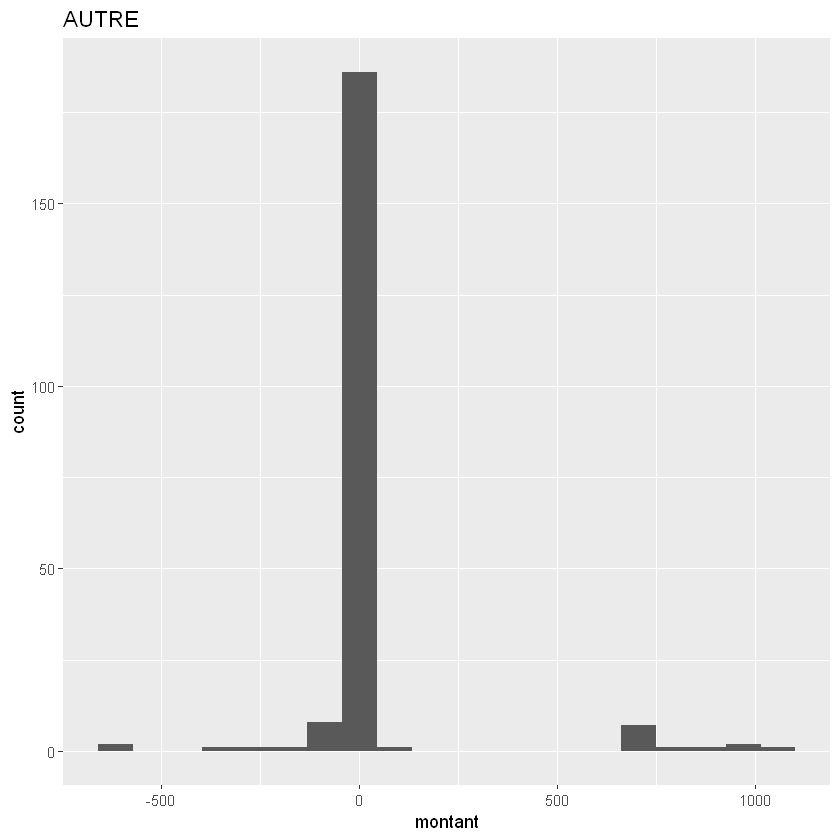

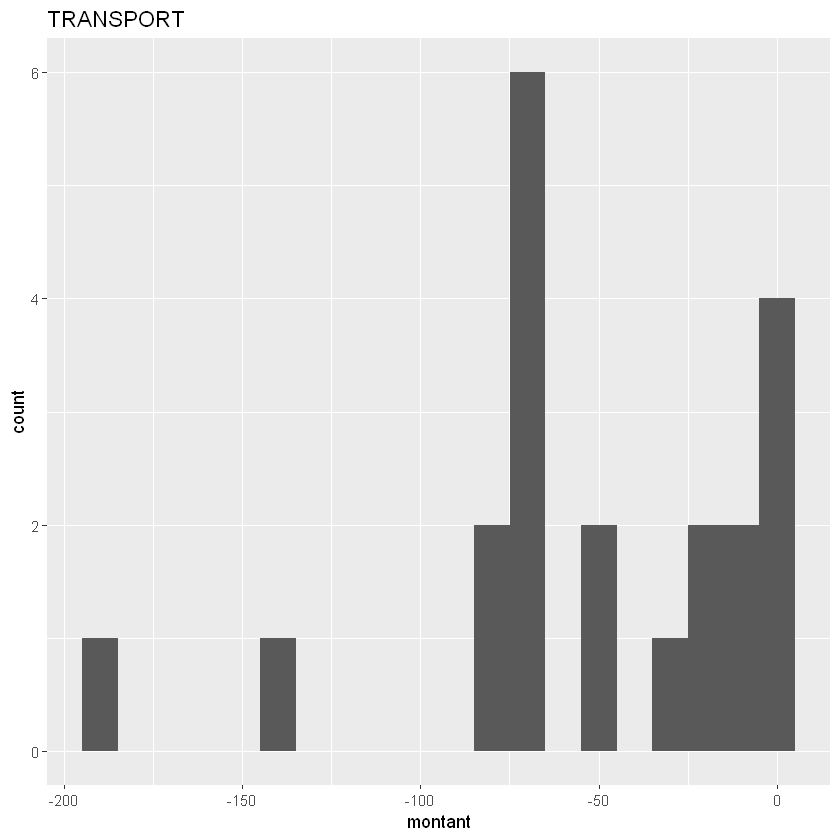

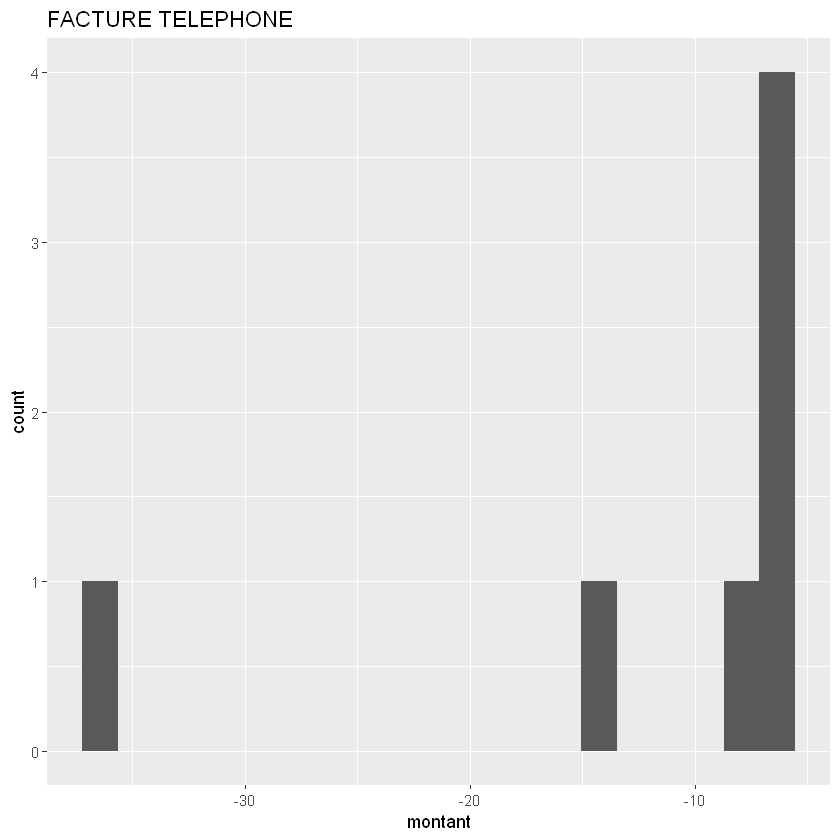

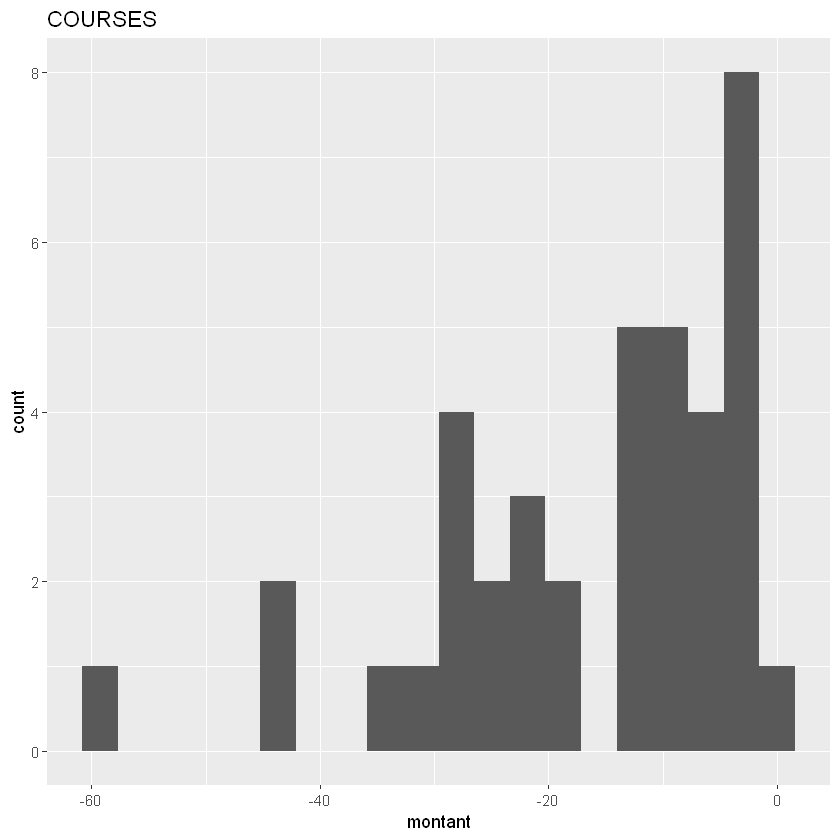

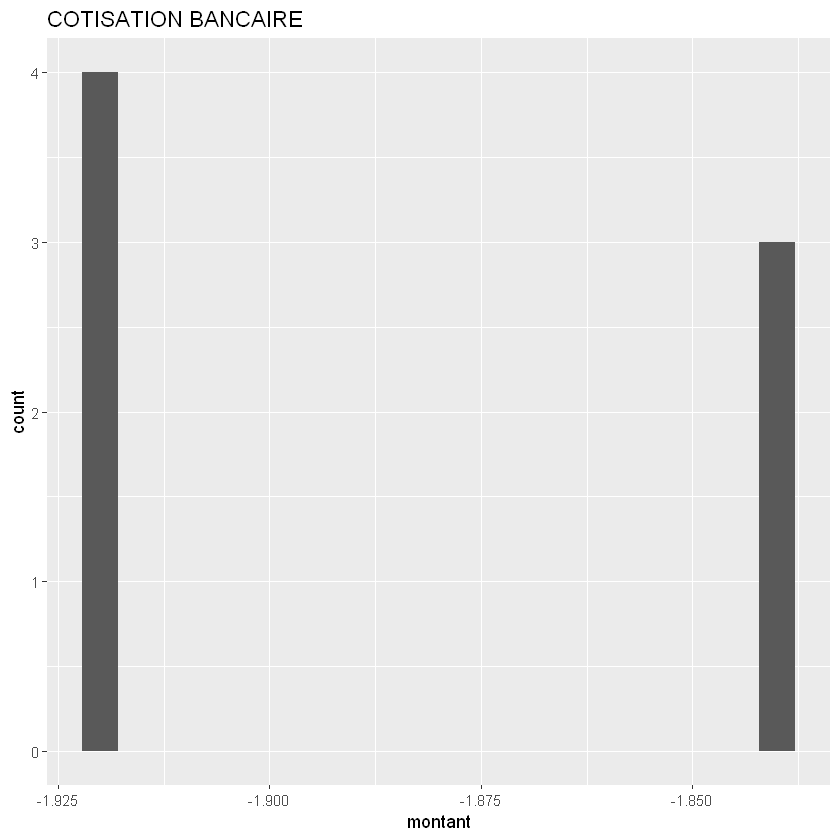

Warning message:
"Computation failed in `stat_bin()`:
`binwidth` must be positive"

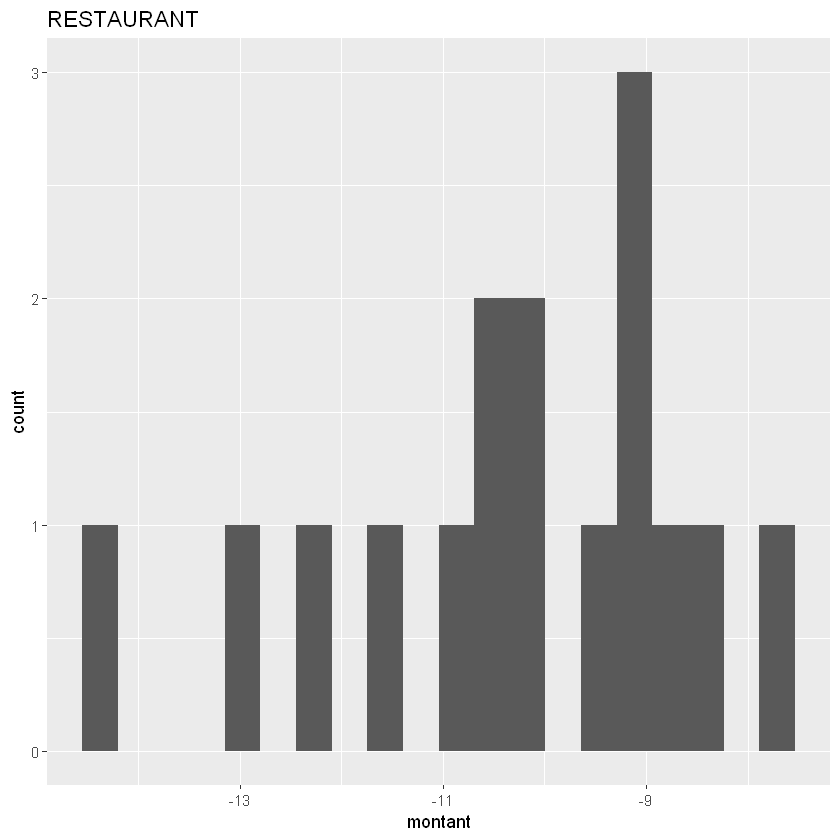

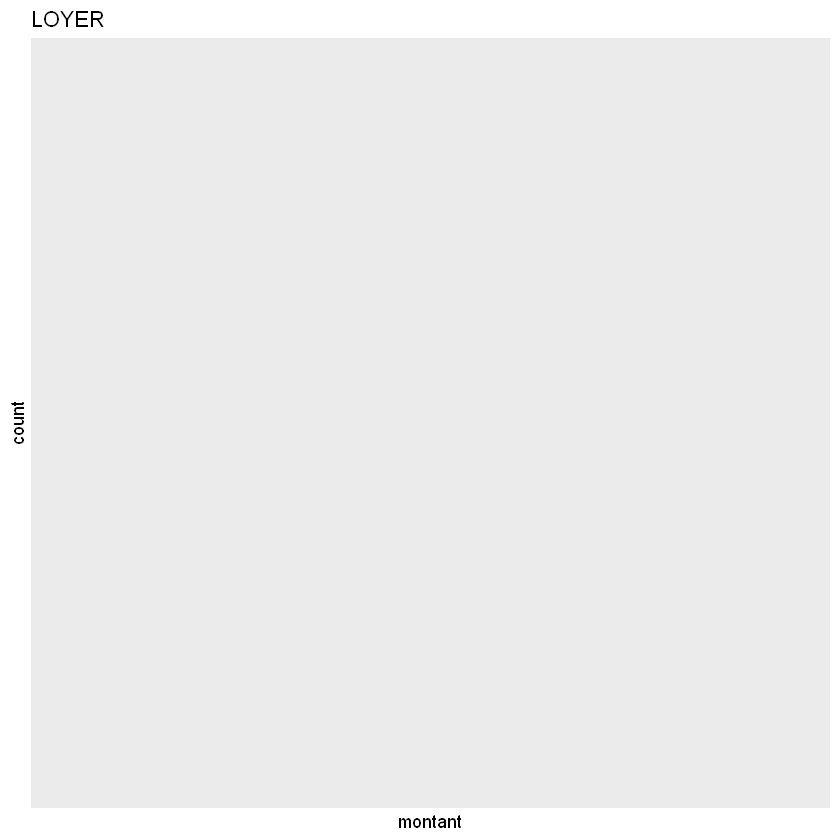

In [28]:
for(cat in unique(data$categ)){
    sous_echantillon = data[data$categ == cat,] # Création du sous-échantillon
    print("--------------------")
    print(cat)
    print("mod");print(mode(sous_echantillon$montant))
    print("moy");print(mean(sous_echantillon$montant))
    print("med");print(median(sous_echantillon$montant))
}

for(cat in unique(data$categ)){
    sous_echantillon = data[data$categ == cat,]
    print(ggplot(sous_echantillon, aes(montant)) + geom_histogram(bins=20) + labs(title=cat)) # Création de l'histogramme
}

Pour chaque catégorie, on crée un sous-échantillon (subset) qui contient uniquement les opérations de la catégorie en cours. On affiche en lignes 5 à 7 les 3 mesures, et on affiche également l'histogramme pour mettre en perspectives les 3 mesures. A vous d'interpréter vos résultats !

# <a name="C6">P3C5 - Comprenez les mesures de dispersion</a>

Pour calculer la variance en Python, cela se fait très facilement ! Il suffit d'utiliser la méthode .var() sur la variable considérée. Par exemple avec la variable montant :

In [29]:
var(data$montant)

[1] 31007.64

Aussi, vous trouverez souvent une version "corrigée" de la variance empirique, que l'on qualifie de non biaisée. En effet, quand on se plonge dans les calculs, on s'aperçoit que la variance empirique donne des valeurs qui (en moyenne) sont inférieures à la variance de la variable aléatoire. Il s'agit de la notion de biais d'un estimateur. Un estimateur sans biais est meilleur qu'un estimateur biaisé.

Pour corriger ce biais, on a créé la variance empirique corrigée, ou variance empirique sans biais. Voici comment calculer la variance empirique corrigée en R :

In [30]:
n = length(data$montant)
var(data$montant)*(n-1)/n

[1] 30906.96

Voilà comment calculer l'écart-type de la variable montant :

In [31]:
sd(data$montant)

[1] 176.0899

Mais lorsque vous faites un trajet, un écart-type de 6,55 minutes sur un trajet de 1 h (1h en moyenne), ce n'est pas la même chose qu'un écart-type de 6,55 minutes sur un trajet de 24 h (24h en moyenne) ! Pour remédier à cela, on a donc créé le coefficient de variation qui est l'écart-type empirique divisé par la moyenne.

Le calcul de ce dernier en R est tout aussi simple :

In [32]:
n = length(data$montant)
sd(data$montant)*(n-1)/n

[1] 175.5181

Nous pouvons facilement construire une boîte à moustaches avec Python :

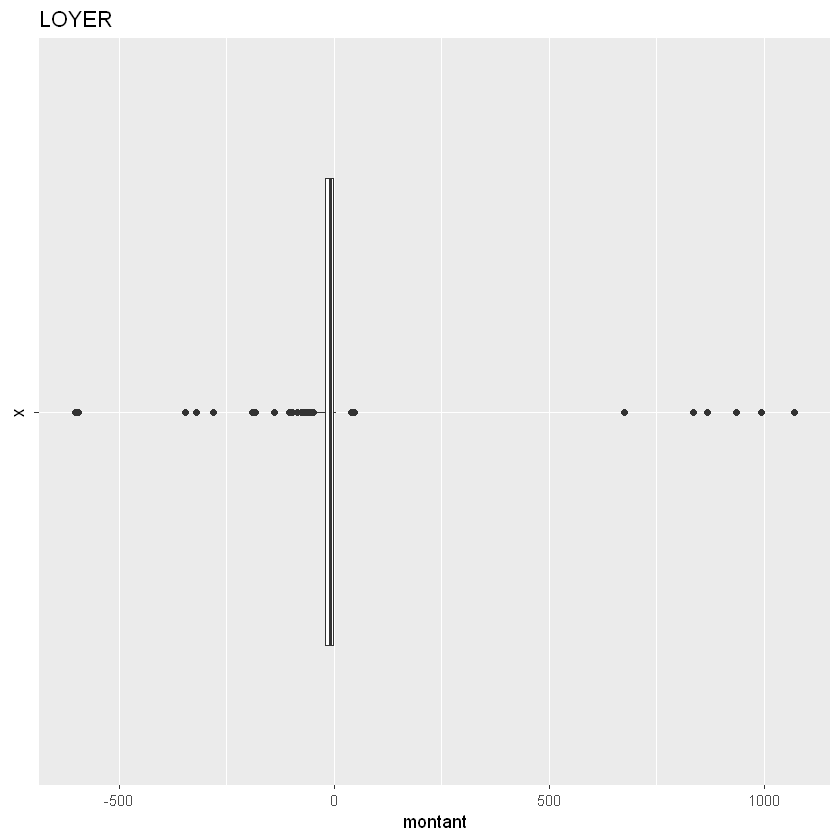

In [33]:
ggplot(data, aes(x="", y=montant)) + geom_boxplot() + coord_flip() + labs(title=cat)

À votre tour ! Reprenez le code développé lors du chapitre précédent, en y ajoutant pour chaque catégorie :
- l'écart-type ;
- la variance ;
- un histogramme ;
- une boîte à moustache des montants.

[1] "--------------------"
[1] "AUTRE"
[1] "mod"
[1] -1.6
[1] "moy"
[1] 23.43321
[1] "med"
[1] -8.31
[1] "var"
[1] 40593.31
[1] "std"
[1] 201.4778
[1] "--------------------"
[1] "TRANSPORT"
[1] "mod"
[1] -73
[1] "moy"
[1] -52.99714
[1] "med"
[1] -53.1
[1] "var"
[1] 2315.268
[1] "std"
[1] 48.11723
[1] "--------------------"
[1] "FACTURE TELEPHONE"
[1] "mod"
[1] -7.02
[1] "moy"
[1] -12.04571
[1] "med"
[1] -7.02
[1] "var"
[1] 122.5222
[1] "std"
[1] 11.06898
[1] "--------------------"
[1] "COURSES"
[1] "mod"
[1] -6.8
[1] "moy"
[1] -16.34128
[1] "med"
[1] -12.24
[1] "var"
[1] 181.6839
[1] "std"
[1] 13.47902
[1] "--------------------"
[1] "COTISATION BANCAIRE"
[1] "mod"
[1] -1.92
[1] "moy"
[1] -1.885714
[1] "med"
[1] -1.92
[1] "var"
[1] 0.001828571
[1] "std"
[1] 0.0427618
[1] "--------------------"
[1] "RESTAURANT"
[1] "mod"
[1] -9.2
[1] "moy"
[1] -10.3325
[1] "med"
[1] -10.1
[1] "var"
[1] 3.043407
[1] "std"
[1] 1.744536
[1] "--------------------"
[1] "LOYER"
[1] "mod"
[1] -345
[1] "moy"
[1]

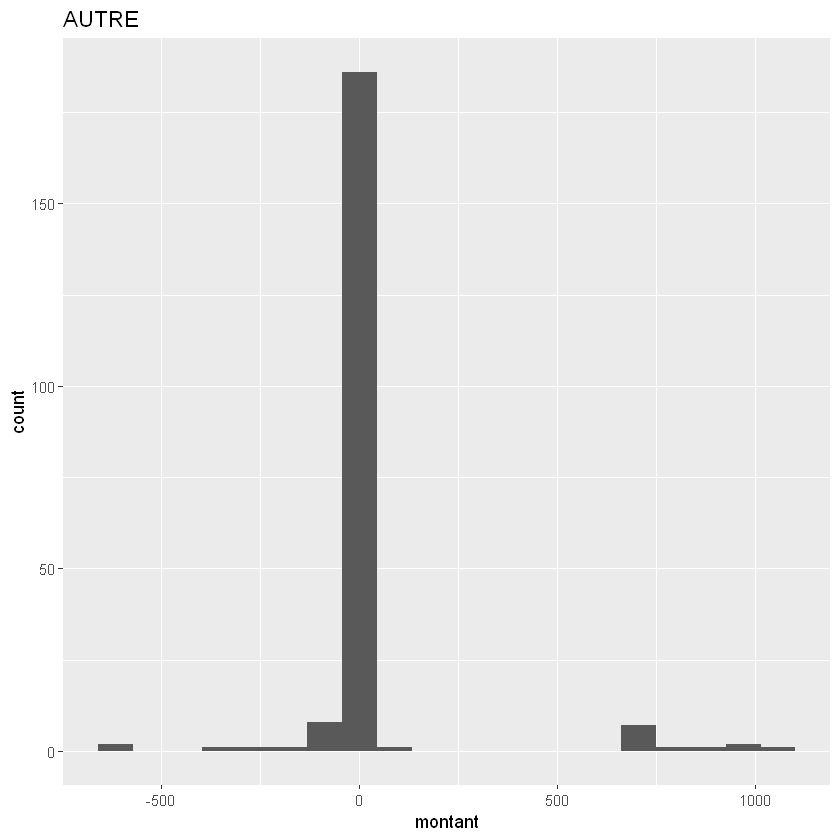

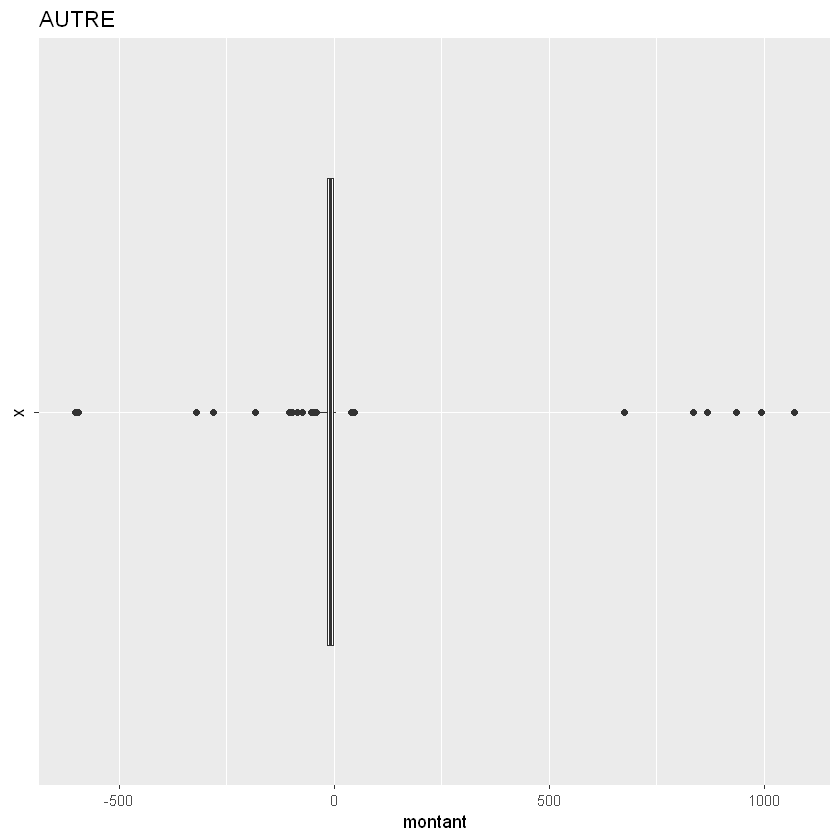

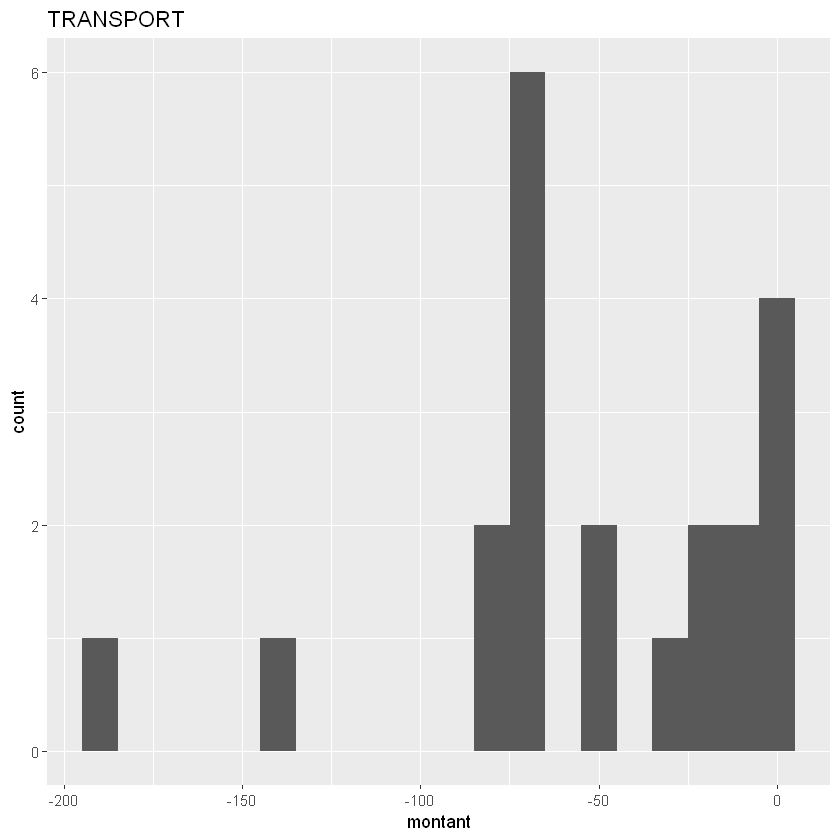

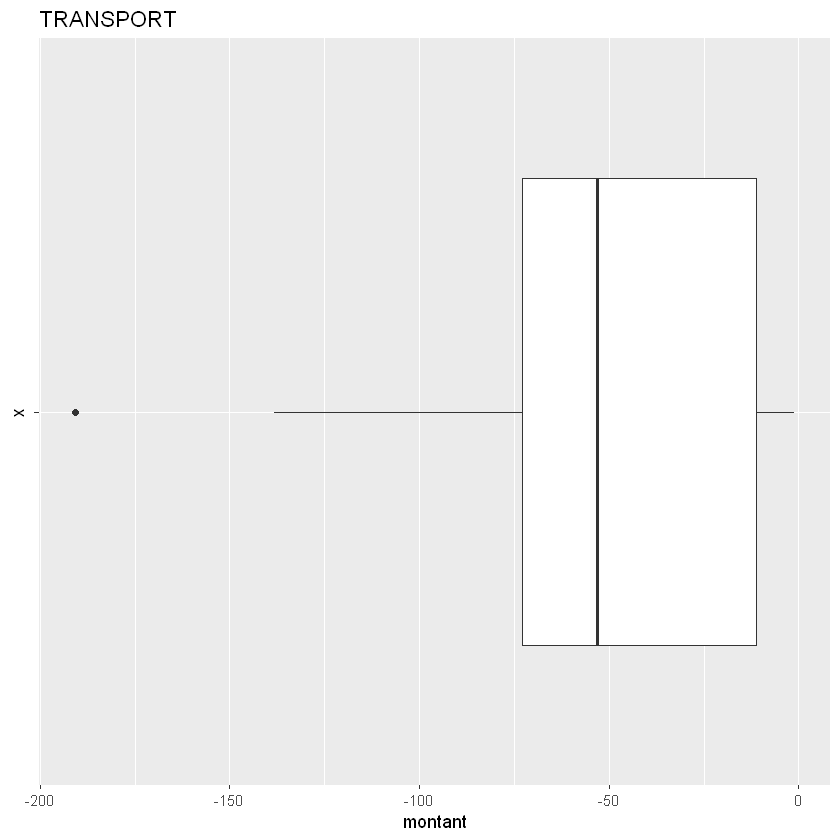

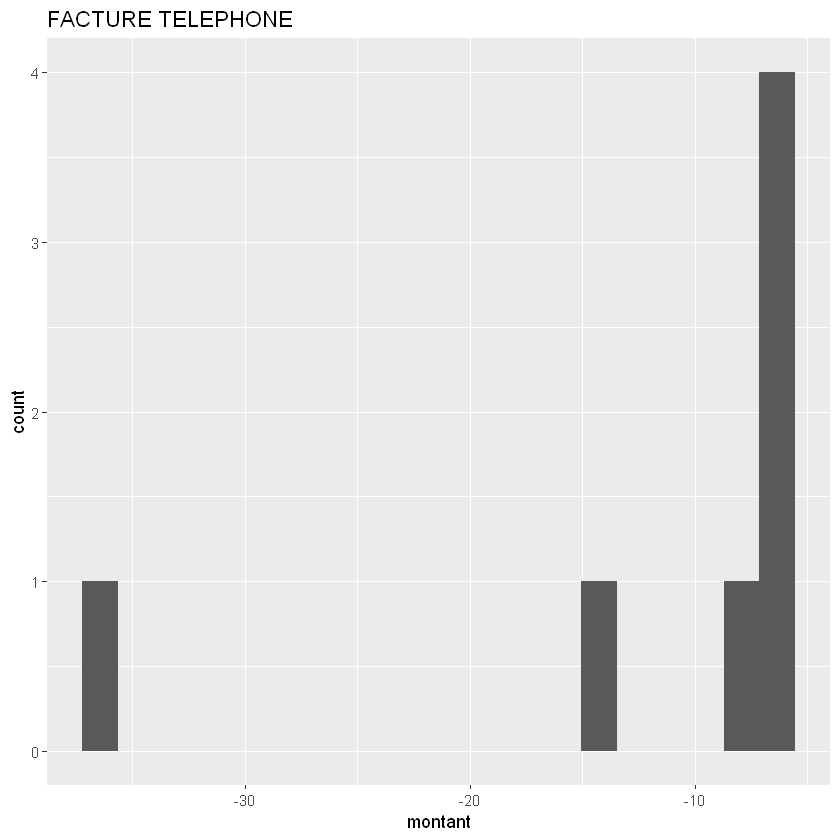

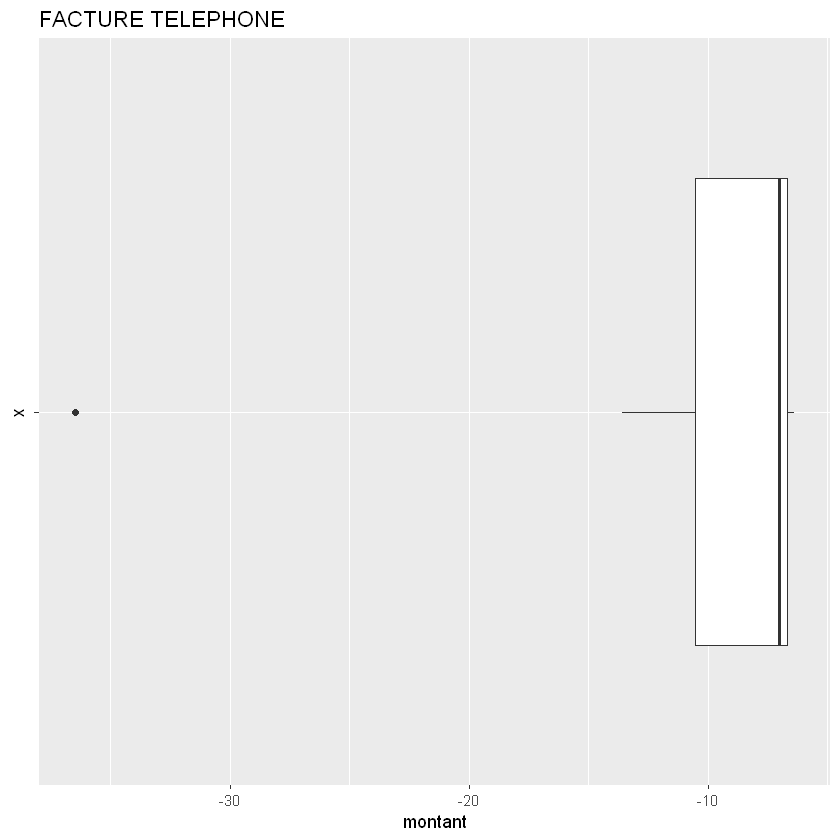

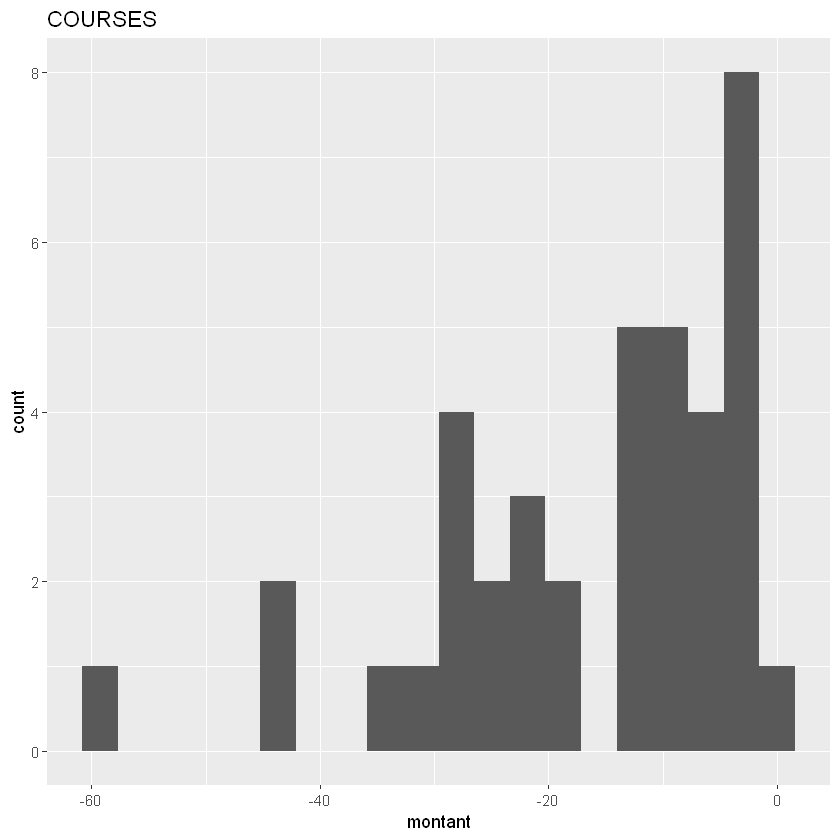

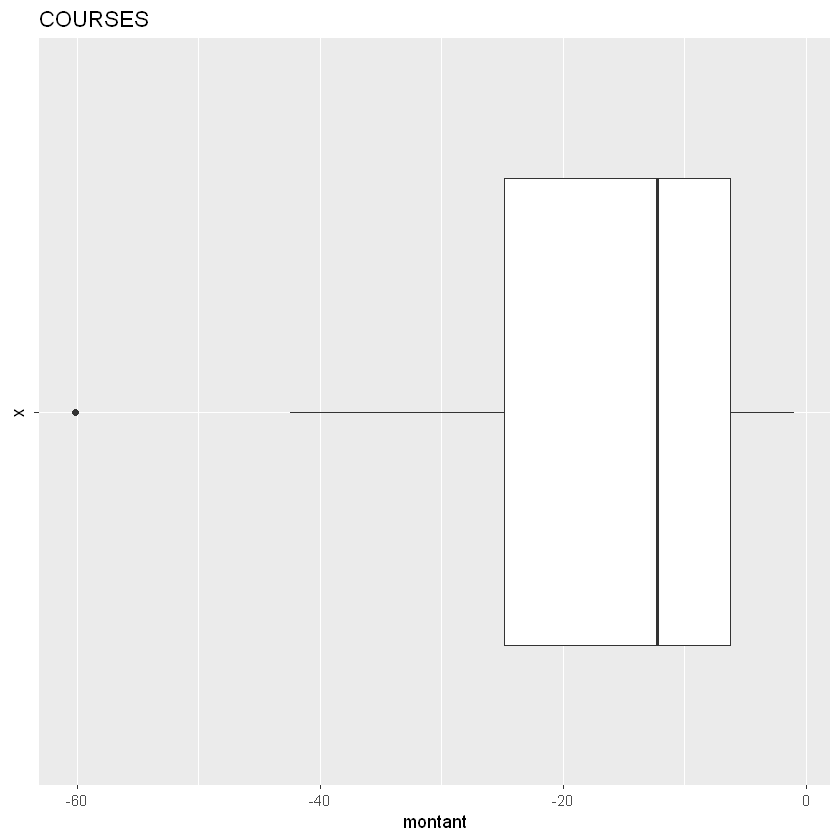

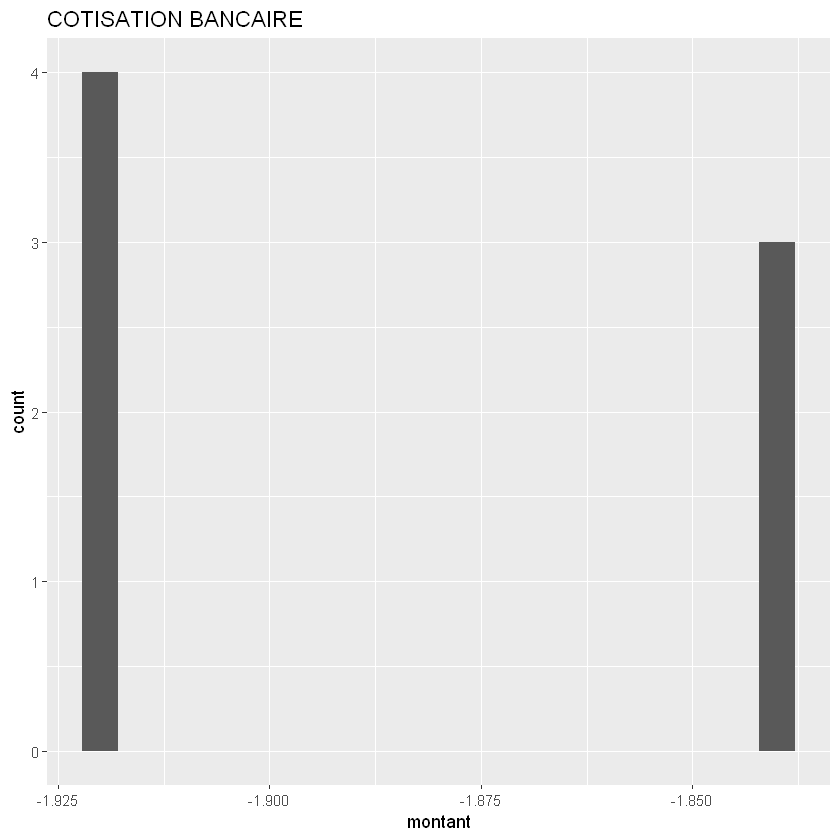

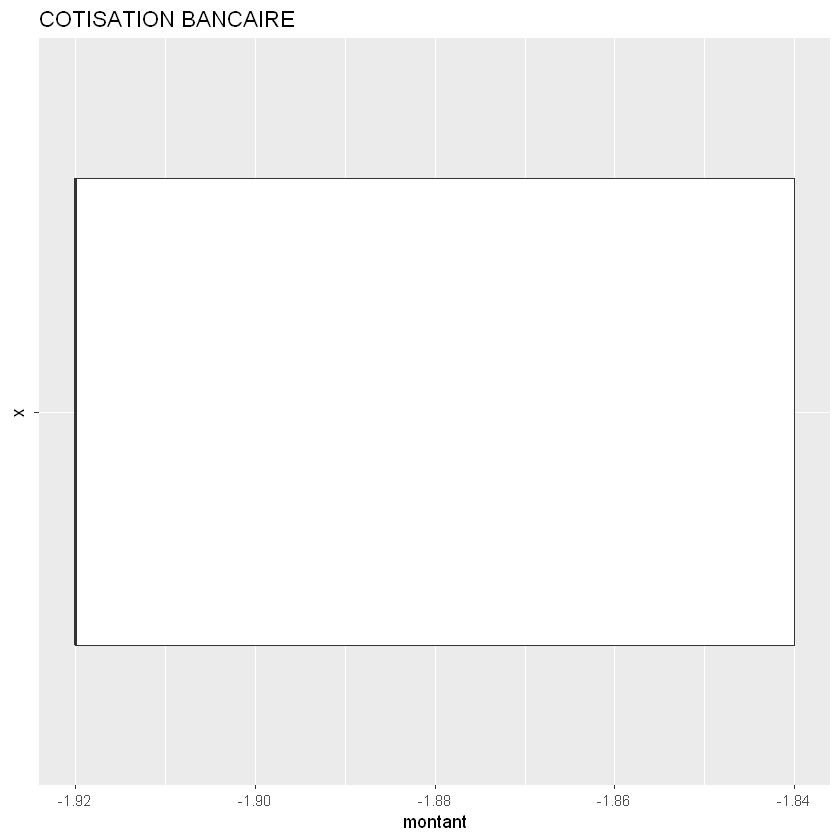

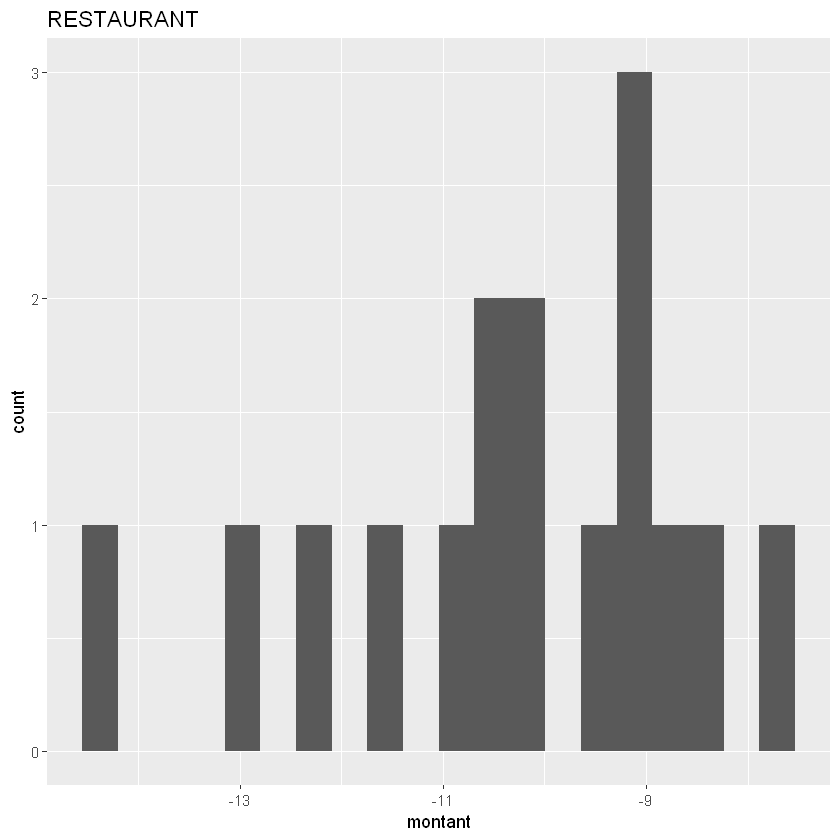

Warning message:
"Computation failed in `stat_bin()`:
`binwidth` must be positive"

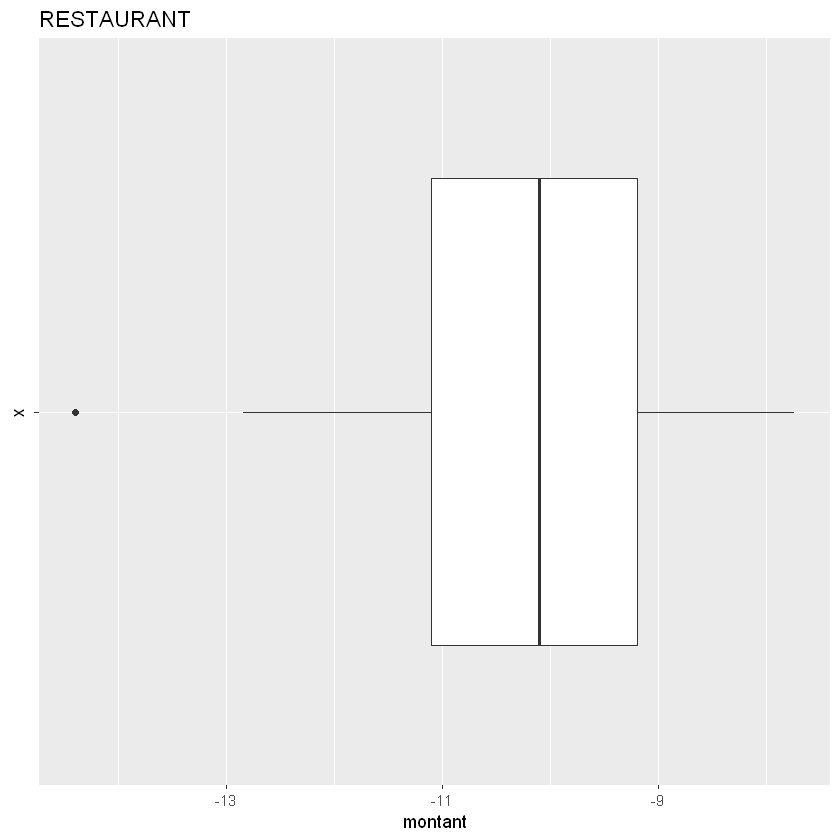

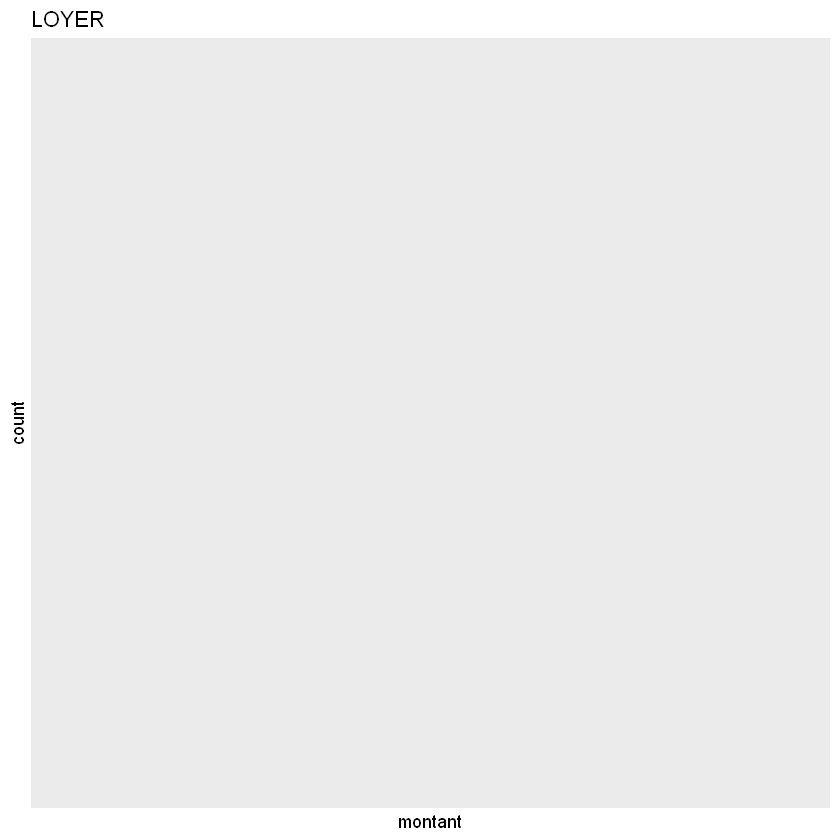

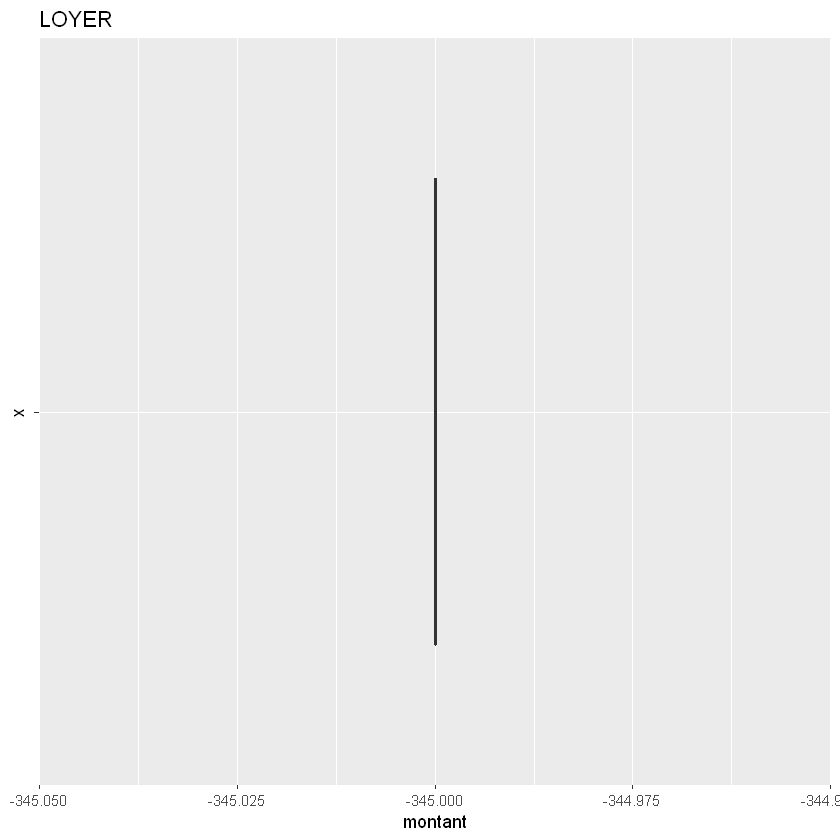

In [34]:
for(cat in unique(data$categ)){
    sous_echantillon = data[data$categ == cat,] # Création du sous-échantillon
    print("--------------------")
    print(cat)
    print("mod");print(mode(sous_echantillon$montant))
    print("moy");print(mean(sous_echantillon$montant))
    print("med");print(median(sous_echantillon$montant))
    print("var");print(var(sous_echantillon$montant))
    print("std");print(sd(sous_echantillon$montant))
}

for(cat in unique(data$categ)){
    sous_echantillon = data[data$categ == cat,]
    print(ggplot(sous_echantillon, aes(montant)) + geom_histogram(bins=20) + labs(title=cat)) # Création de l'histogramme
    print(ggplot(sous_echantillon, aes(x="", y=montant)) + geom_boxplot() + coord_flip() + labs(title=cat))
}

 La variance du montant des opérations de la catégorie LOYER est nulle, ce qui signifie que le montant du loyer est toujours resté fixe.

# <a name="C7"> P3C6 - Appréhendez les mesures de forme</a>

Le calcul du skewness se fait très facilement en Python :

In [35]:
skewness(data$montant)

[1] 3.34545

Voilà comment calculer le kurtosis de notre variable montant :

In [36]:
kurtosis(data$montant)

[1] 19.97337

Poussez encore votre analyse un peu plus loin ! Ajoutez le calcul du Skewness empirique et le Kurtosis empirique pour chaque catégorie.

[1] "--------------------"
[1] "AUTRE"
[1] "mod"
[1] -1.6
[1] "moy"
[1] 23.43321
[1] "med"
[1] -8.31
[1] "var"
[1] 40593.31
[1] "std"
[1] 201.4778
[1] "skw"
[1] 3.099403
[1] "kur"
[1] 15.39042
[1] "--------------------"
[1] "TRANSPORT"
[1] "mod"
[1] -73
[1] "moy"
[1] -52.99714
[1] "med"
[1] -53.1
[1] "var"
[1] 2315.268
[1] "std"
[1] 48.11723
[1] "skw"
[1] -1.157273
[1] "kur"
[1] 4.431265
[1] "--------------------"
[1] "FACTURE TELEPHONE"
[1] "mod"
[1] -7.02
[1] "moy"
[1] -12.04571
[1] "med"
[1] -7.02
[1] "var"
[1] 122.5222
[1] "std"
[1] 11.06898
[1] "skw"
[1] -1.842113
[1] "kur"
[1] 4.666068
[1] "--------------------"
[1] "COURSES"
[1] "mod"
[1] -6.8
[1] "moy"
[1] -16.34128
[1] "med"
[1] -12.24
[1] "var"
[1] 181.6839
[1] "std"
[1] 13.47902
[1] "skw"
[1] -1.198275
[1] "kur"
[1] 4.256251
[1] "--------------------"
[1] "COTISATION BANCAIRE"
[1] "mod"
[1] -1.92
[1] "moy"
[1] -1.885714
[1] "med"
[1] -1.92
[1] "var"
[1] 0.001828571
[1] "std"
[1] 0.0427618
[1] "skw"
[1] 0.2886751
[1] "kur"
[1

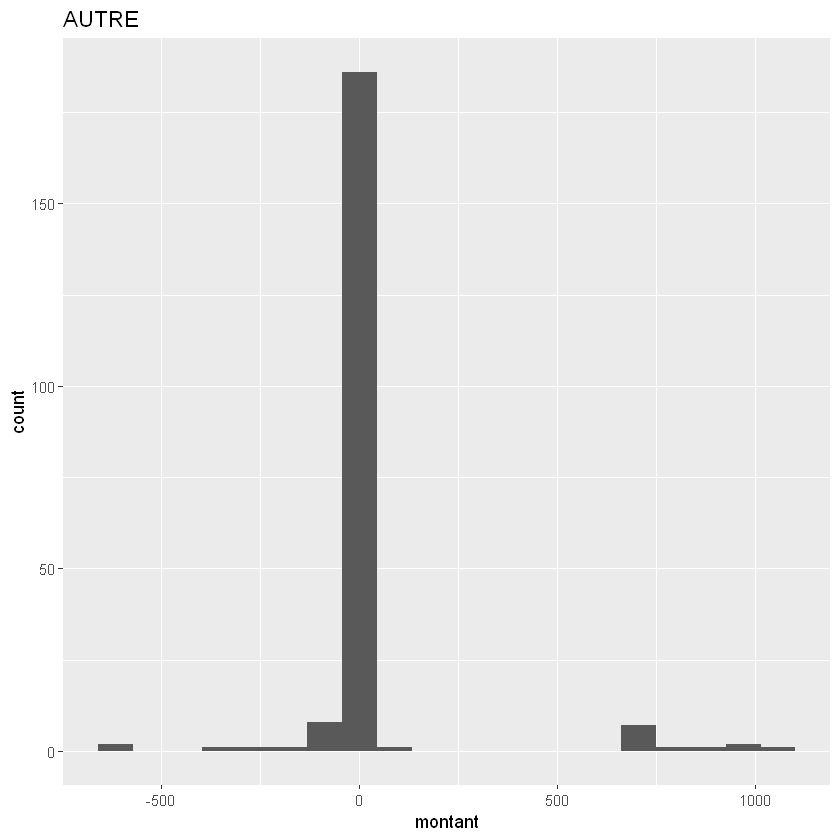

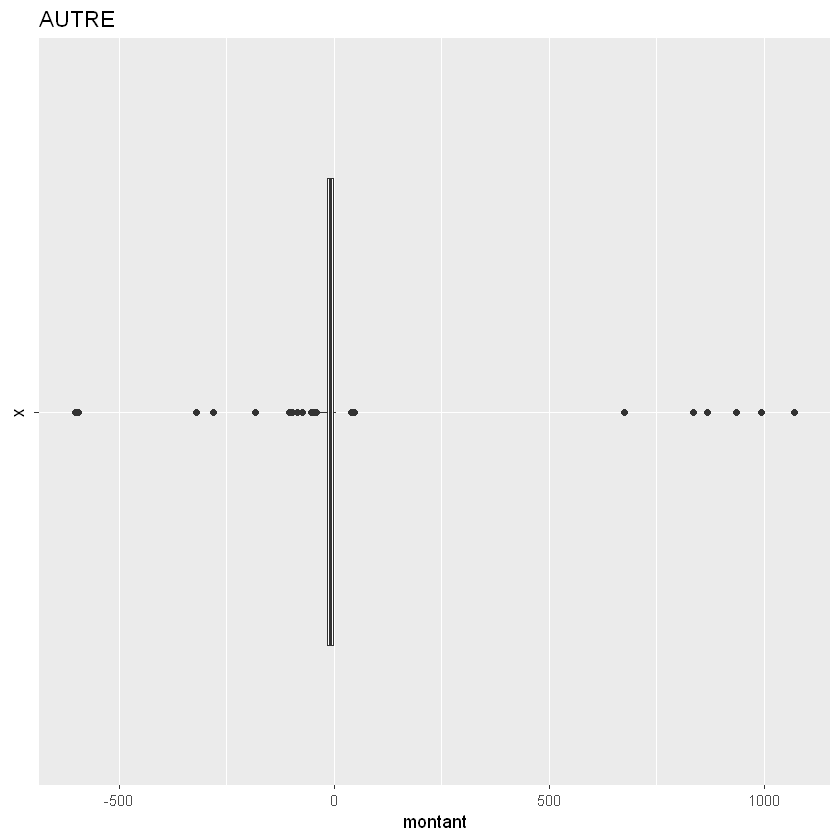

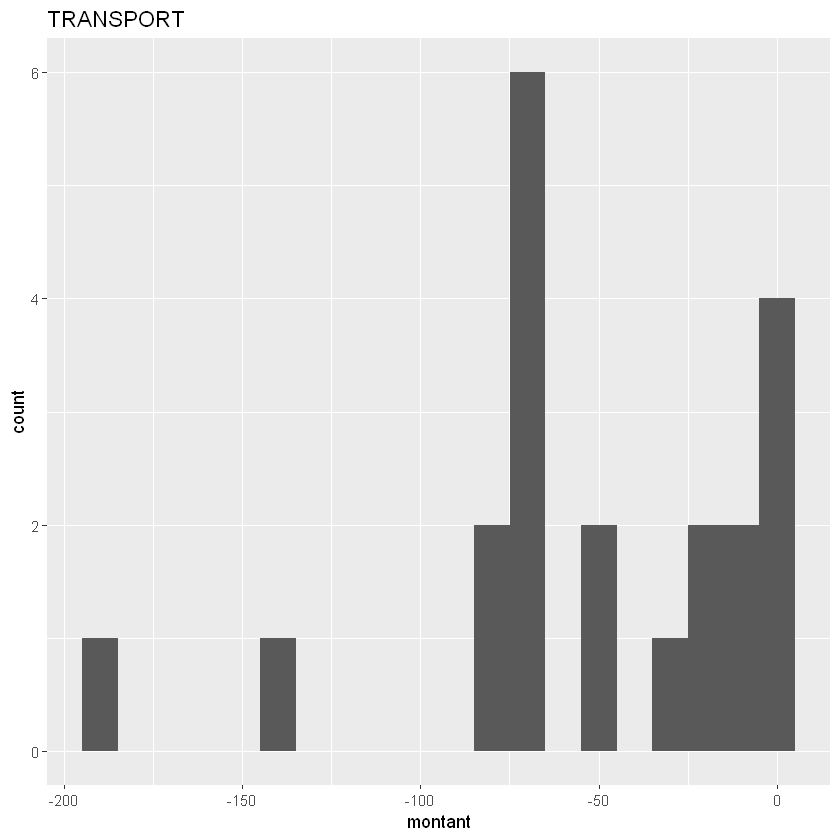

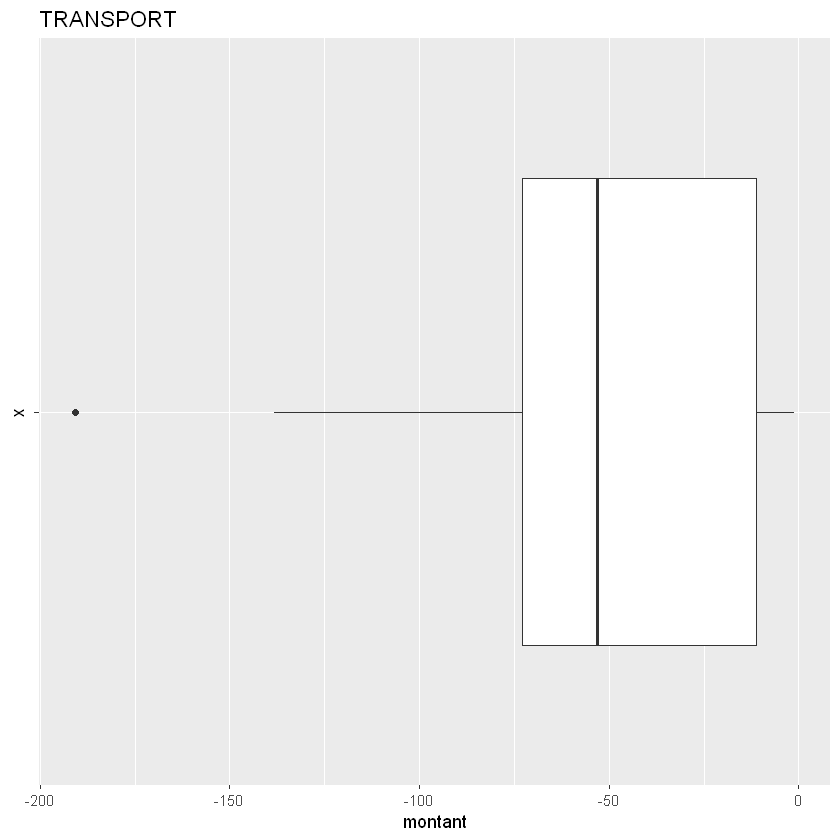

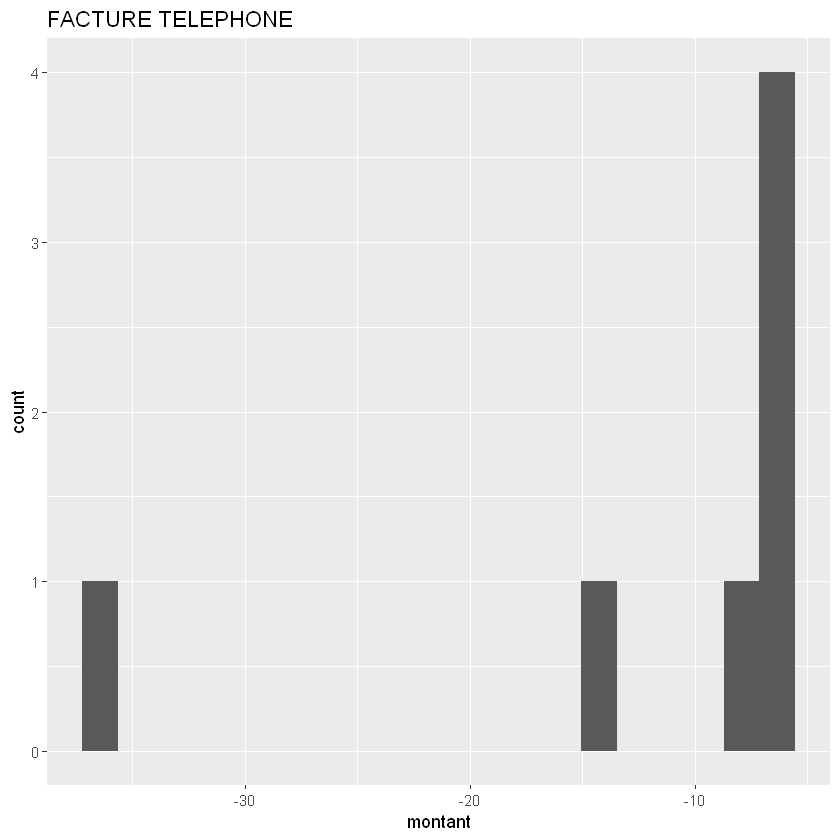

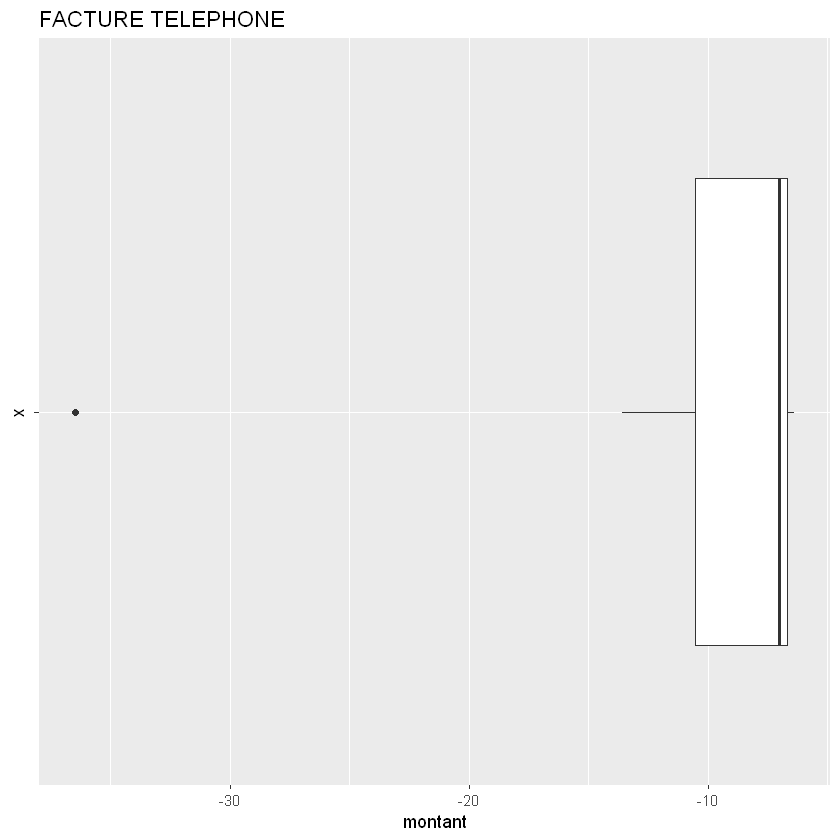

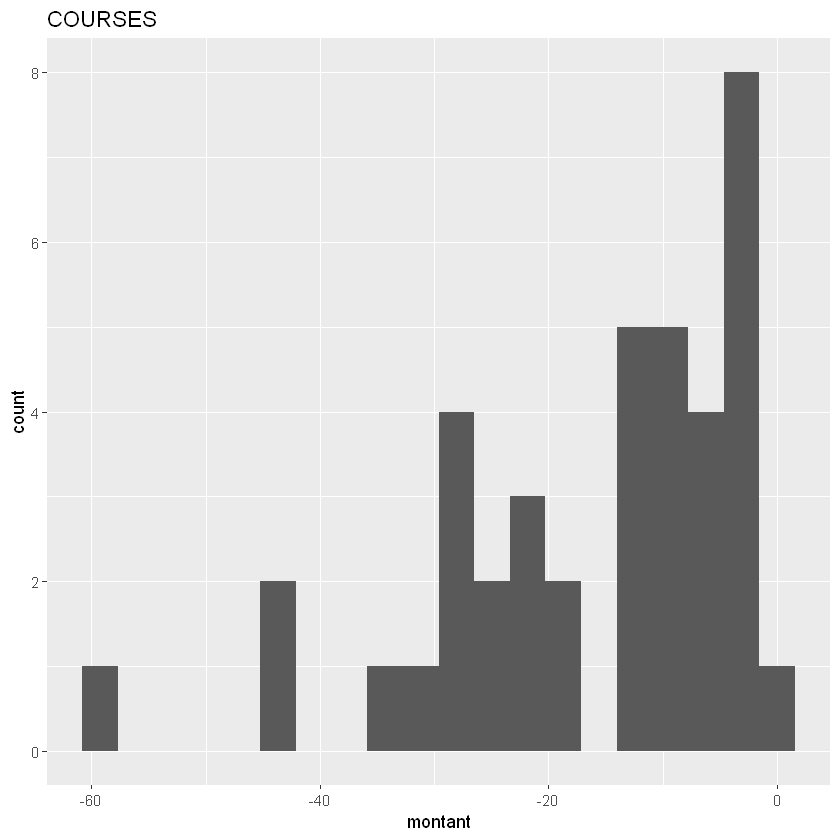

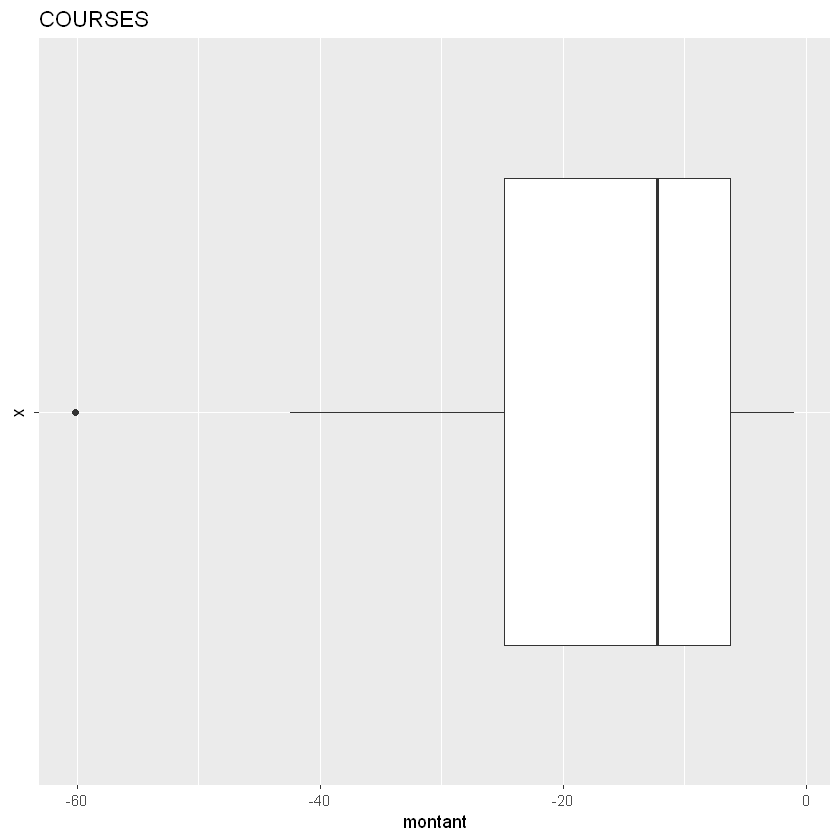

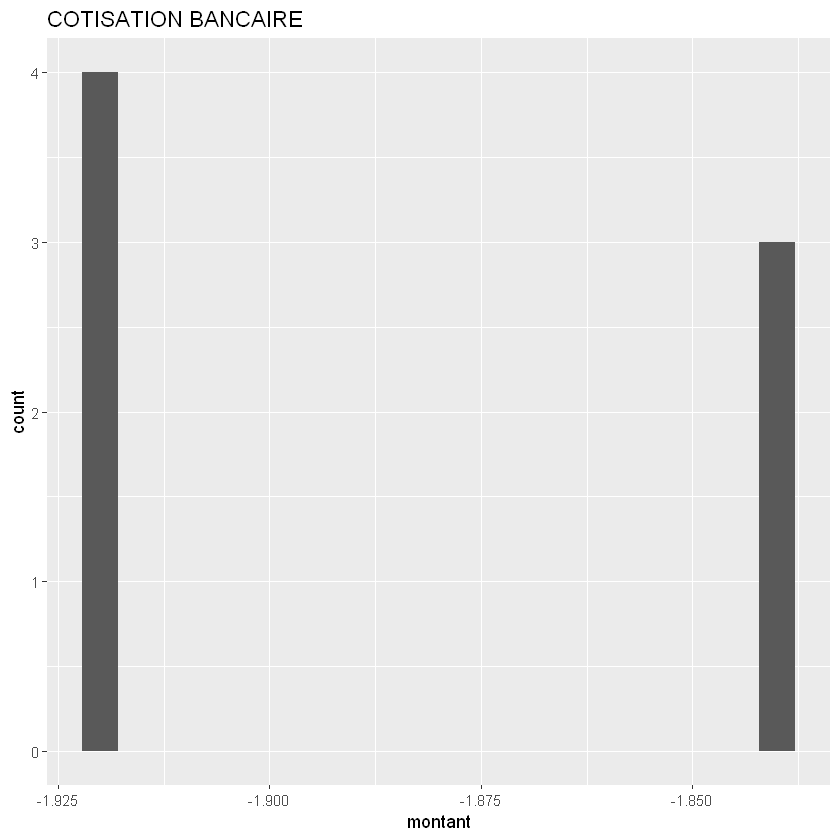

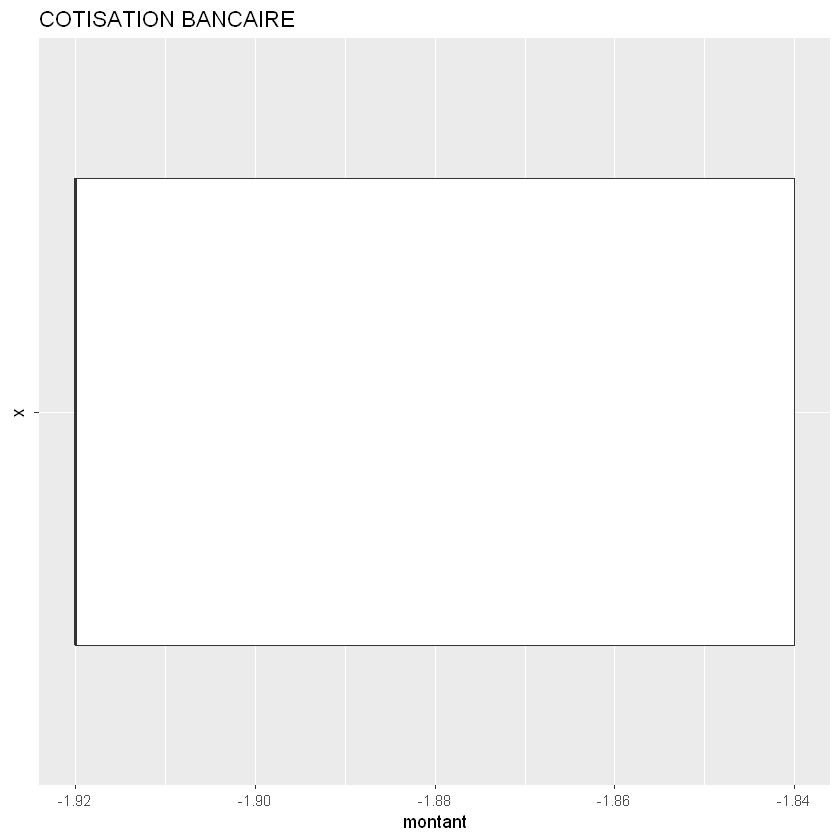

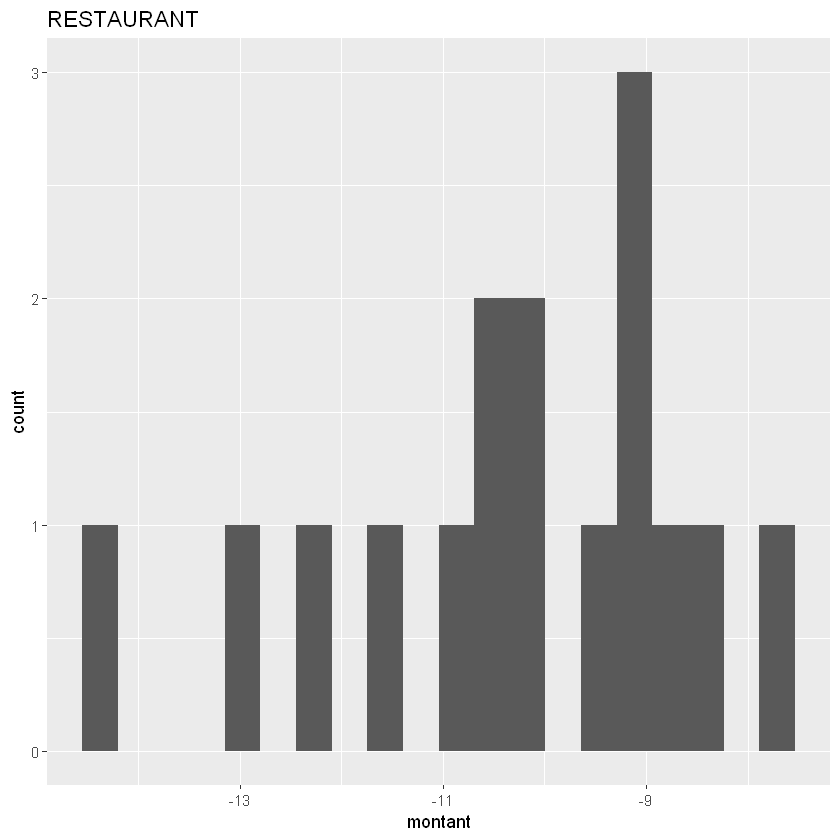

Warning message:
"Computation failed in `stat_bin()`:
`binwidth` must be positive"

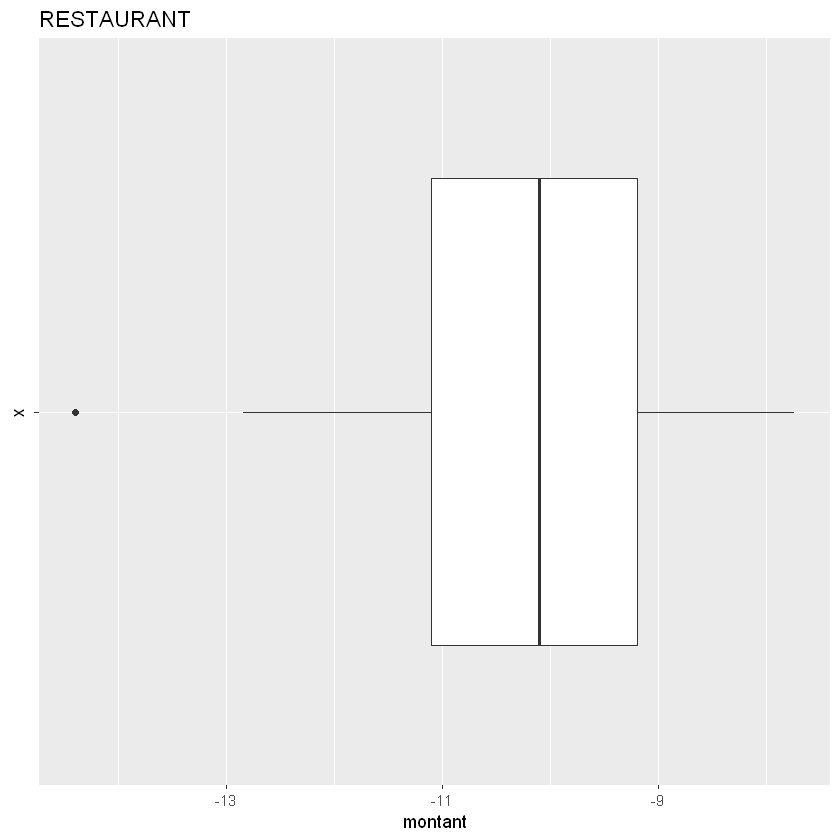

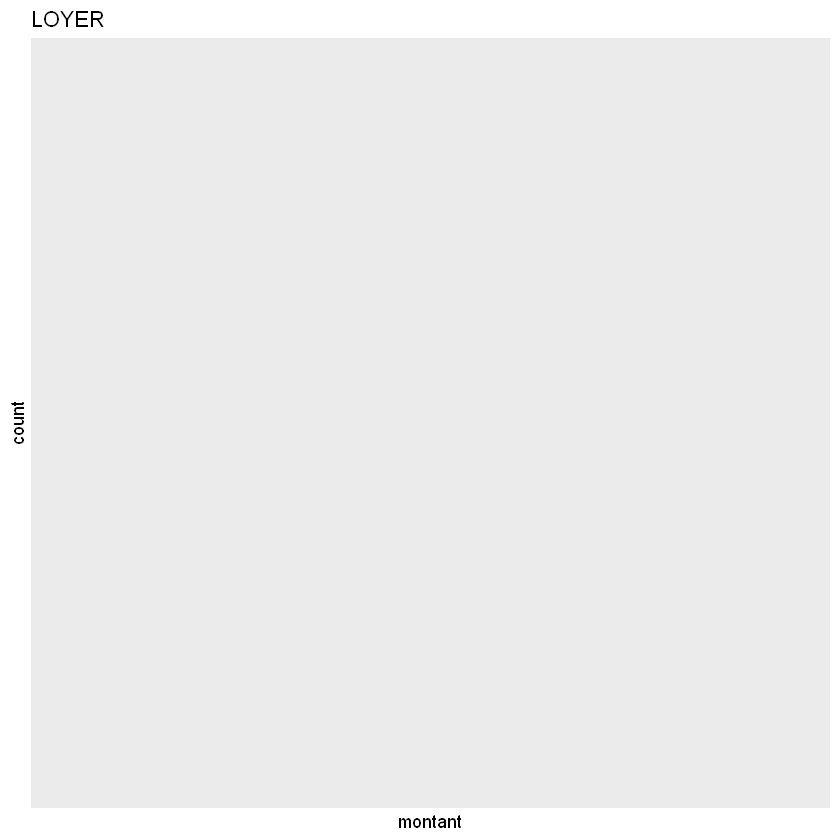

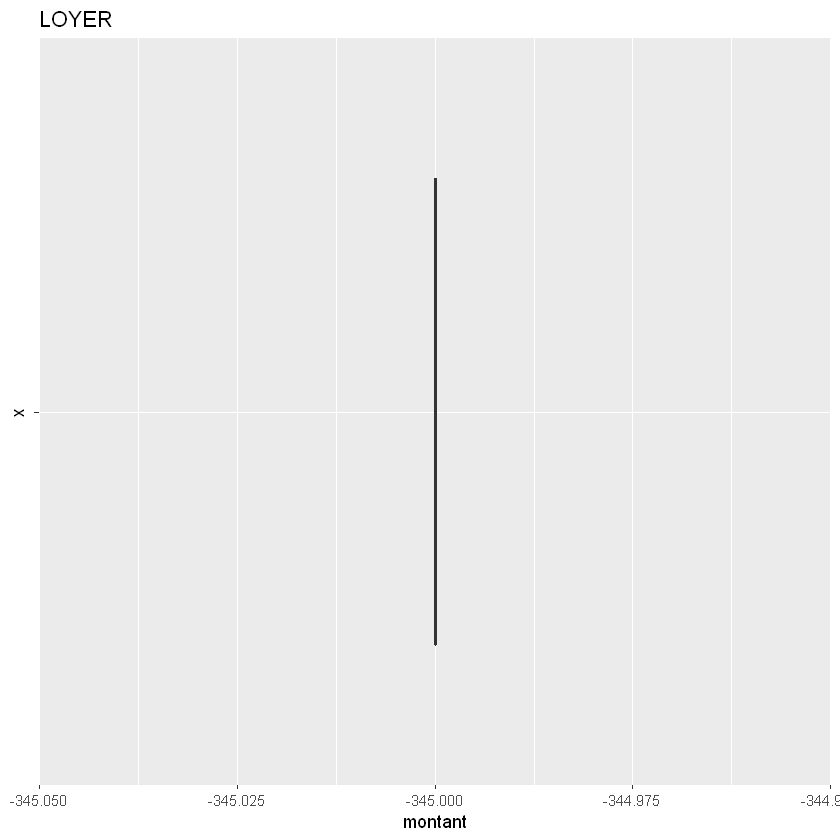

In [37]:
for(cat in unique(data$categ)){
    sous_echantillon = data[data$categ == cat,] # Création du sous-échantillon
    print("--------------------")
    print(cat)
    print("mod");print(mode(sous_echantillon$montant))
    print("moy");print(mean(sous_echantillon$montant))
    print("med");print(median(sous_echantillon$montant))
    print("var");print(var(sous_echantillon$montant))
    print("std");print(sd(sous_echantillon$montant))
    print("skw");print(skewness(sous_echantillon$montant))
    print("kur");print(kurtosis(sous_echantillon$montant))
}

for(cat in unique(data$categ)){
    sous_echantillon = data[data$categ == cat,]
    print(ggplot(sous_echantillon, aes(montant)) + geom_histogram(bins=20) + labs(title=cat)) # Création de l'histogramme
    print(ggplot(sous_echantillon, aes(x="", y=montant)) + geom_boxplot() + coord_flip() + labs(title=cat))
}

Pour toutes les opérations dont la catégorie regroupe principalement des dépenses (téléphone, courses, etc.), il est assez normal que le skewness empirique soit négatif. La distribution des dépenses s'étale vers la gauche, car on fait fréquemment des petites dépenses, et moins souvent des dépenses qui parfois peuvent être très importantes (donc très à gauche)

# <a name="C8">P3C7 - Familiarisez-vous avec les mesures de concentration</a>

Voici le code permettant d'afficher la courbe de Lorenz :

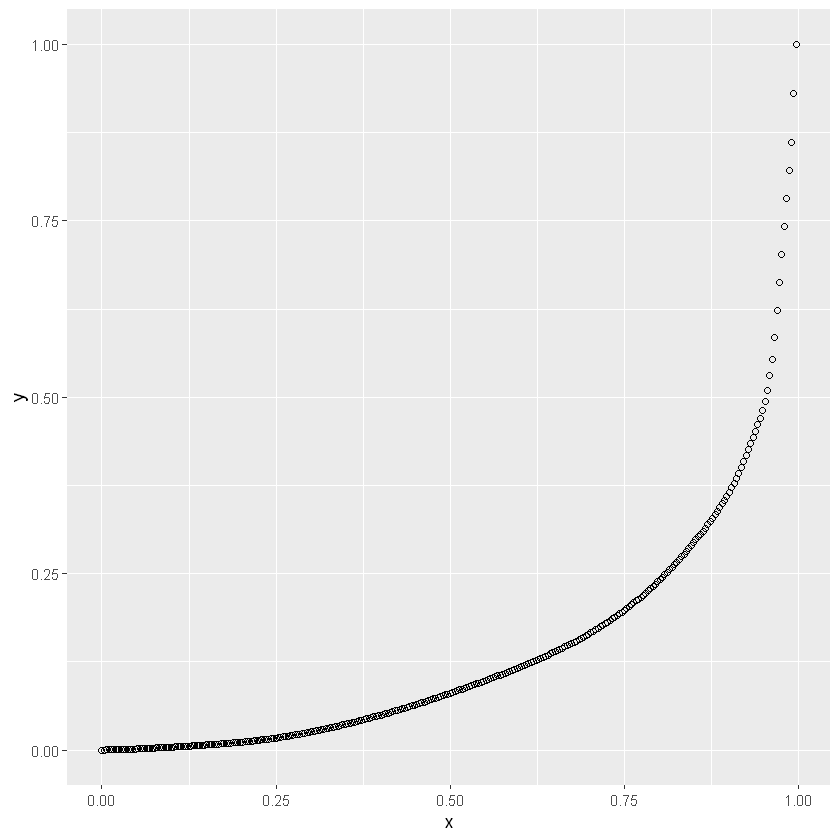

In [38]:
depenses = data[data['montant'] < 0,]
dep = -depenses$montant
lorenz = cumsum(sort(dep)) / sum(dep)
lorenz = c(0,lorenz) # La courbe de Lorenz commence à 0

n = length(lorenz)
lorenz_df = data.frame(x=((0:(n-1))/n), y=lorenz)

ggplot(lorenz_df, aes(x,y)) + geom_point(shape=1)

On y sélectionne tout d'abord le sous-échantillon de travail que l'on appelle  depenses  . Comme évoqué plus haut, il faut trier les individus dans l'ordre croissant des valeurs de la variable ; nous le faisons ici grâce à la fonction `sort()`, car  dep  contient les observations de la variable montant.

Ensuite, nous calculons la somme cumulée grâce à la fonction `cumsum()`. Pour normaliser et faire en sorte que le haut de la courbe soit à 1, on divise le tout par  `sum()`. La variable  lorenz  contient les ordonnées des points, mais il nous faut maintenant leurs abscisses : celles-ci s'étendent de 0 à 1 (comme évoqué précédemment) à intervalle réguliers. C'est ce que produit `lorenz_df = data.frame(x=((0:(n-1))/n), y=lorenz)`

Le calcul de l'indice de Gini reprend directement les variables issues du traçage de la courbe de Lorenz mais est un peu plus complexe à comprendre, je laisse les plus courageux s'y plonger ;)

In [39]:
n = length(lorenz)
aire_ss_courbe = sum(lorenz[1:(n-1)])/n # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

[1] 0.7248207

# <a name="C9"> P4C3 - Analysez la corrélation entre deux variables quantitatives</a>

Posons-nous la question suivante :

    Êtes-vous moins dépensier lorsque vous avez peu d'argent sur votre compte ?

Vous l'aurez deviné, les 2 variables à étudier sont : montant et solde_avt_operation. Rechercher une corrélation entre ces variables revient à dire : "Sachant que le solde de votre compte est petit, peut-on s'attendre à ce que le montant de l'opération soit lui aussi petit ?" (ou l'inverse).

Je vous invite donc à tracer le diagramme de dispersion entre le solde avant opération et le montant des dépenses, et analyser ce qui en ressort.

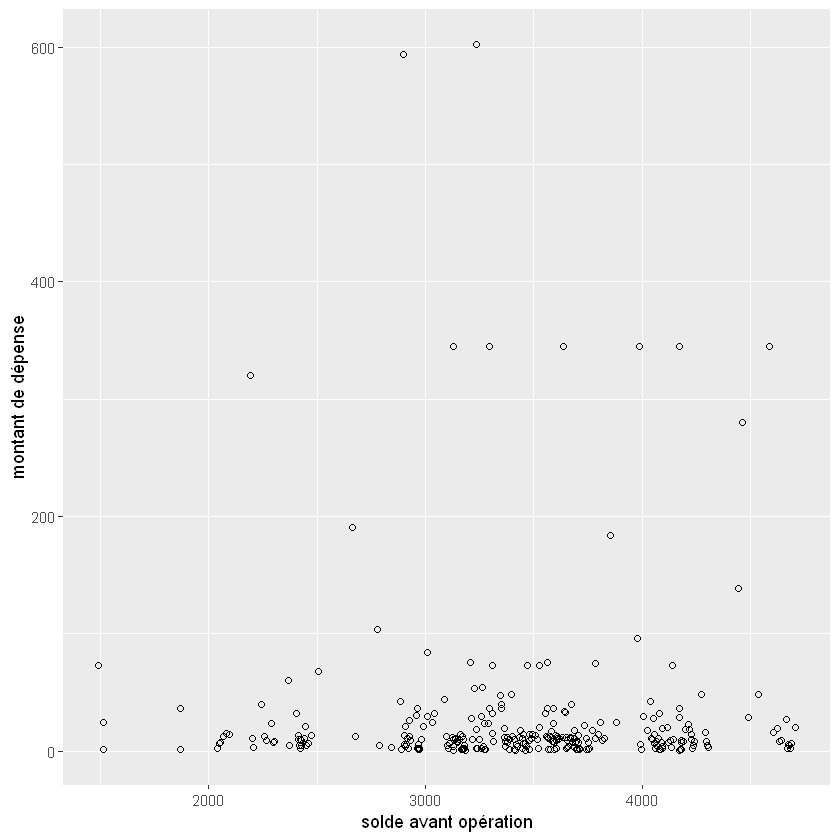

In [40]:
depenses = data[data$montant < 0,]
depenses$montant = -depenses$montant

ggplot(depenses, aes(solde_avt_ope,montant)) + geom_point(shape=1) + 
    labs(x="solde avant opération", y="montant de dépense")

A priori sur ce diagramme de dispersion, il ne semble pas que quand le solde est petit, les montants soient particulièrement petits. Il semble ne pas y avoir de corrélation. Mais vous en trouverez peut-être une dans vos propres relevés !

Pour calculer le coefficient de Pearson et la covariance, 2 lignes suffisent !

In [41]:
cor(depenses$solde_avt_ope, depenses$montant, method="pearson")
cov(depenses$solde_avt_ope, depenses$montant)

# calcule la covariance empirique corrigée.
# Multiplier par (n-1)/n pour obtenir la covariance empirique
# avec n = nrow(depenses)

[1] 0.01006882

[1] 486.6318

# <a name="C10"> P4C4 - Analysez deux variables quantitatives par régression linéaire</a>

Tout d'abord, il faut calculer la variable attente ! Voici le code permettant de créer cela :

In [42]:
# Selection du sous-échantillon
courses = data[data$categ == "COURSES",]

# On trie les opérations par date
courses = courses[order(courses$date_operation),]

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = c()
last_date = Sys.Date()
for(i in 1:nrow(courses)){
    days = as.Date(courses[i,"date_operation"])-last_date
    days = as.numeric(days, units="days")
    if(days == 0)
        r = c(r,r[length(r)])
    else
        r = c(r,days)
    last_date = as.Date(courses[i,"date_operation"])
}
courses["attente"] = r
courses = courses[2:nrow(courses),]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = aggregate(courses$montant,list(courses$date_operation),FUN=sum)
b = aggregate(courses$attente,list(courses$date_operation),FUN=(function (x) x[1])) 
courses = data.frame(montant=a$x,attente=b$x)

On crée ici au final un sous-échantillon qui ne contient que les opérations de catégorie courses, et que l'on appelle...  courses  !


Essayons d'afficher le diagramme de dispersion avec X = attente et Y = montant, et regardons si tous les points sont alignés :

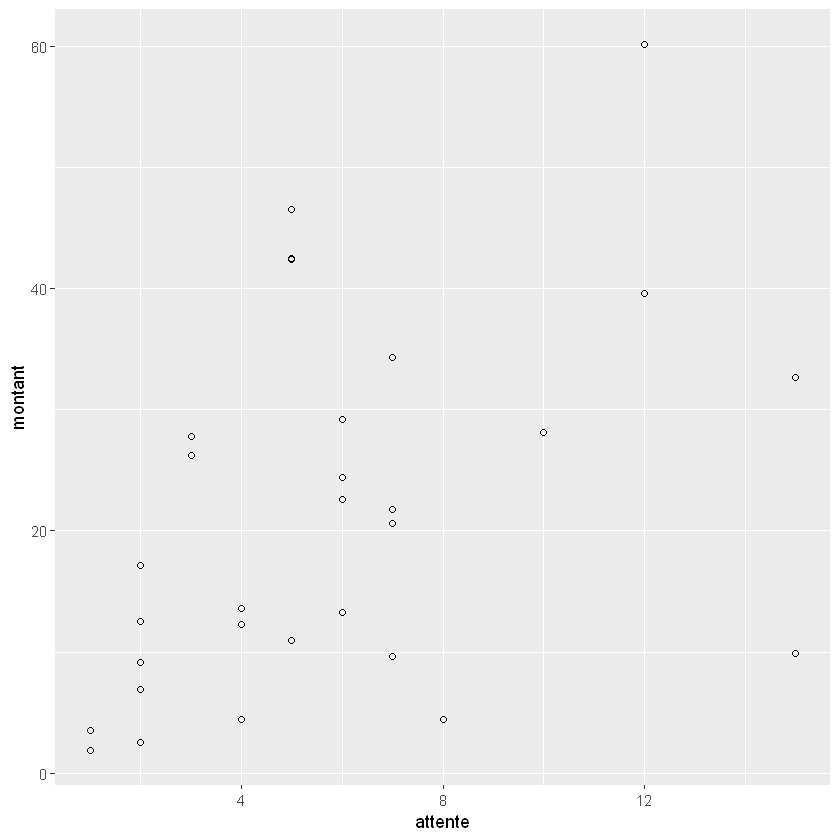

In [43]:
ggplot(courses, aes(attente,montant)) + geom_point(shape=1) + 
    labs(x="attente", y="montant")

On peut à présent effectuer notre régression linéaire. Voici comment estimer a et b avec Python. Le code est un peu complexe, mais retenez que la dernière ligne crée les variables  a  et  b  contenant les estimations.

In [44]:
coeffs = lm(montant~attente,data=courses)$coefficients
print(coeffs)
coeffs = as.numeric(coeffs)
a = coeffs[2]
b = coeffs[1]

(Intercept)     attente 
  10.944848    1.736578 


Voici comment tracer la droite de régression à partir des coefficients obtenus :

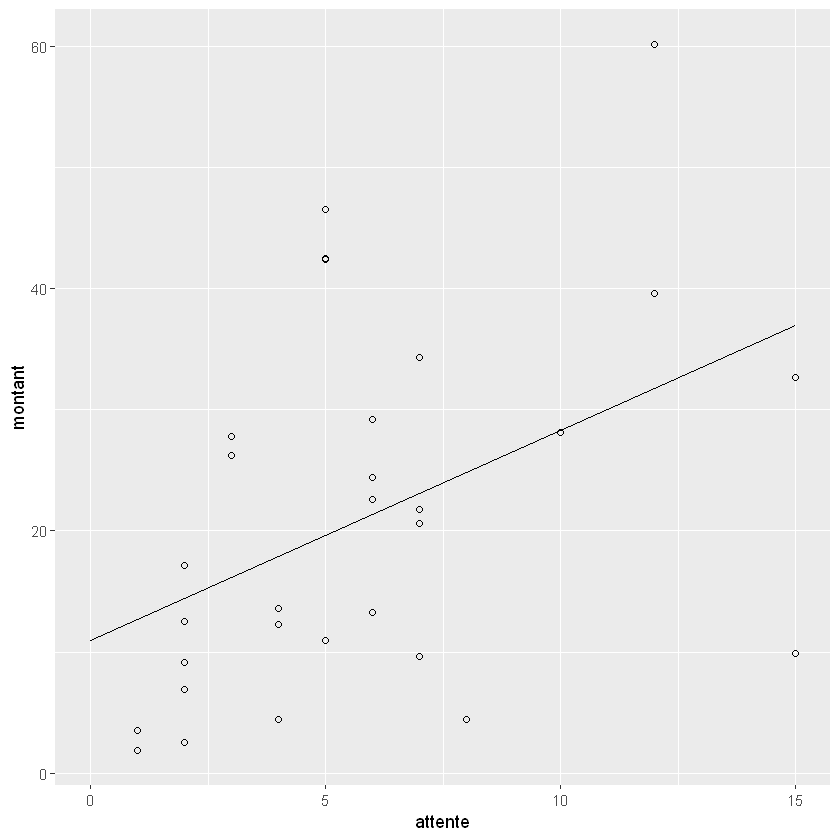

In [45]:
droite = data.frame(x=c(0,15),y=c(a*0+b, a*15+b))
ggplot(courses, aes(attente,montant)) + geom_point(shape=1) + 
    geom_line(data=droite, aes(x=x,y=y))

Régression linéaire sans outliers :

(Intercept)     attente 
   5.411480    3.030823 


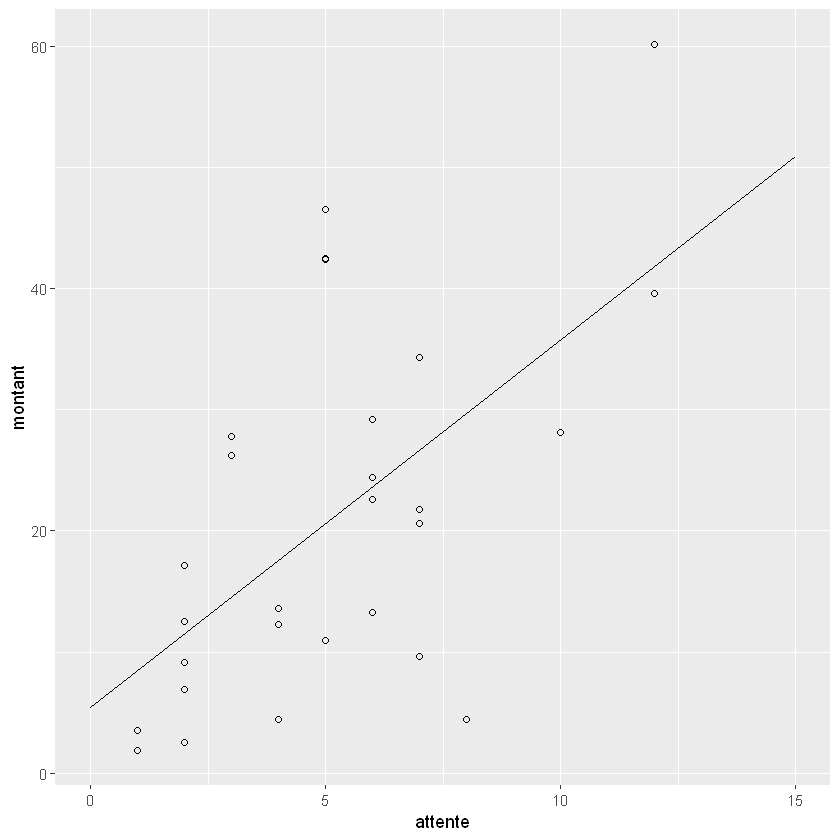

In [46]:
courses = courses[courses$attente < 15,]

coeffs = lm(montant~attente,data=courses)$coefficients
print(coeffs)
coeffs = as.numeric(coeffs)
a = coeffs[2]
b = coeffs[1]

droite = data.frame(x=c(0,15),y=c(a*0+b, a*15+b))
ggplot(courses, aes(attente,montant)) + geom_point(shape=1) + 
    geom_line(data=droite, aes(x=x,y=y))

# <a name="C11"> P4C5 - Analysez une variable quantitative et une qualitative par ANOVA</a>

Voici le code qui permet de représenter une variable quantitative et une variable qualitative. Tout d'abord, créez le sous-échantillon sur lequel vous souhaitez travailler en adaptant ce code, notamment les variables X et Y selon la question que vous aurez choisie parmi celles ci-dessus.

In [47]:
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["montant"] < 0,]
# On remet les dépenses en positif
sous_echantillon["montant"] = -sous_echantillon["montant"]
# On n'étudie pas les loyers car trop gros:
sous_echantillon = sous_echantillon[sous_echantillon["categ"] != "LOYER",] 

Ensuite, ces quelques lignes de code affichent votre graphique !

Warning message:
"Removed 6 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 6 rows containing non-finite values (stat_summary)."

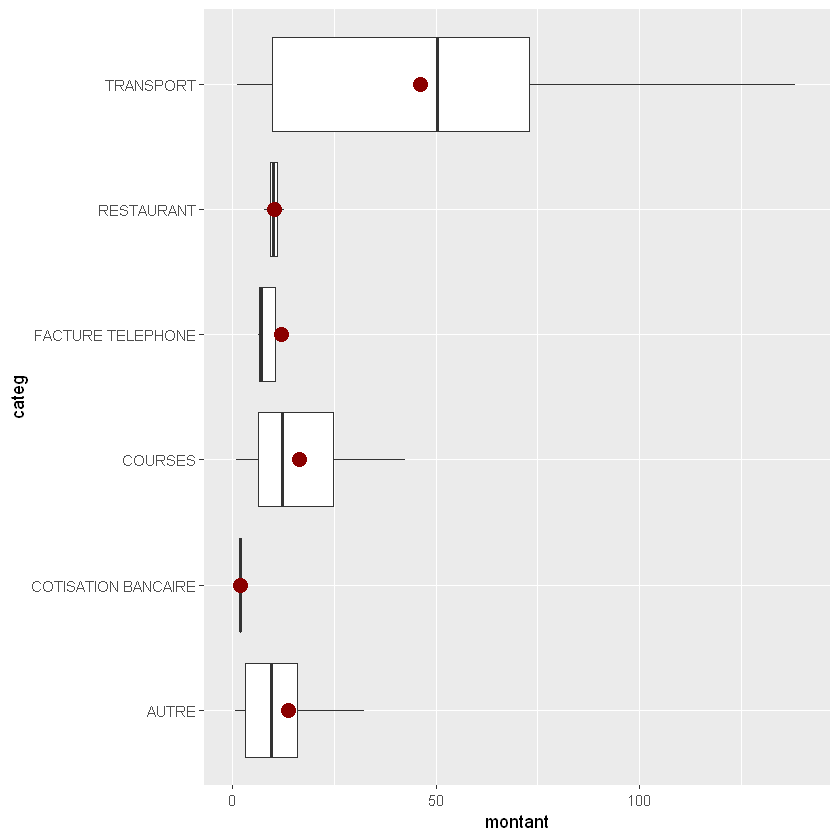

In [48]:
ggplot(sous_echantillon, aes(x=categ, y=montant)) + 
    geom_boxplot(outlier.shape = NA) + coord_flip() + 
    stat_summary(fun.y=mean, colour="darkred", geom="point", shape=19, size=4) +
    scale_y_continuous(limits = c(0,140))

Les points rouges au milieu de chaque boîte à moustaches représentent la moyenne des valeurs.

On voit ici que les montants sont très différents d'une catégorie à l'autre. Par exemple, les montants des dépenses de transport sont plus élevés et plus dispersés que ceux des factures téléphoniques. Mais vérifions maintenant cette affirmation par les chiffres, grâce à une modélisation.

Voici à présent le code permettant de calculer $\eta^2$ (eta carré ou eta squared, en anglais). Je vous propose ici de faire le calcul à la main ;) :

In [49]:
X = "categ" # qualitative
Y = "montant" # quantitative

eta_squared = function(x,y){
    moyenne_y = mean(y)
    classes = c()
    for(classe in unique(x)){
        yi_classe = y[x==classe]
        classes = c(classes,
                    list(
                        list('ni'= length(yi_classe),
                            'moyenne_classe' = mean(yi_classe))))
    }
    SCT = 0
    for(yj in y){SCT = SCT + (yj-moyenne_y)^2}
    SCE = 0
    for(c in classes){
        SCE = SCE + c$ni*(c$moyenne_classe-moyenne_y)^2
    }
    return(SCE/SCT)
}

eta_squared(sous_echantillon[,X],sous_echantillon[,Y])

[1] 0.0275228

On va aller plus loin en analysant la corrélation entre la variable quart_mois créée précédemment et le montant des achats. En effet, il serait intéressant de déterminer si certains jours sont plus "propices" à la dépense que d'autres et pourquoi pas, essayer de dégager les raisons !

Warning message:
"Removed 6 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 6 rows containing non-finite values (stat_summary)."

[1] 0.01139804

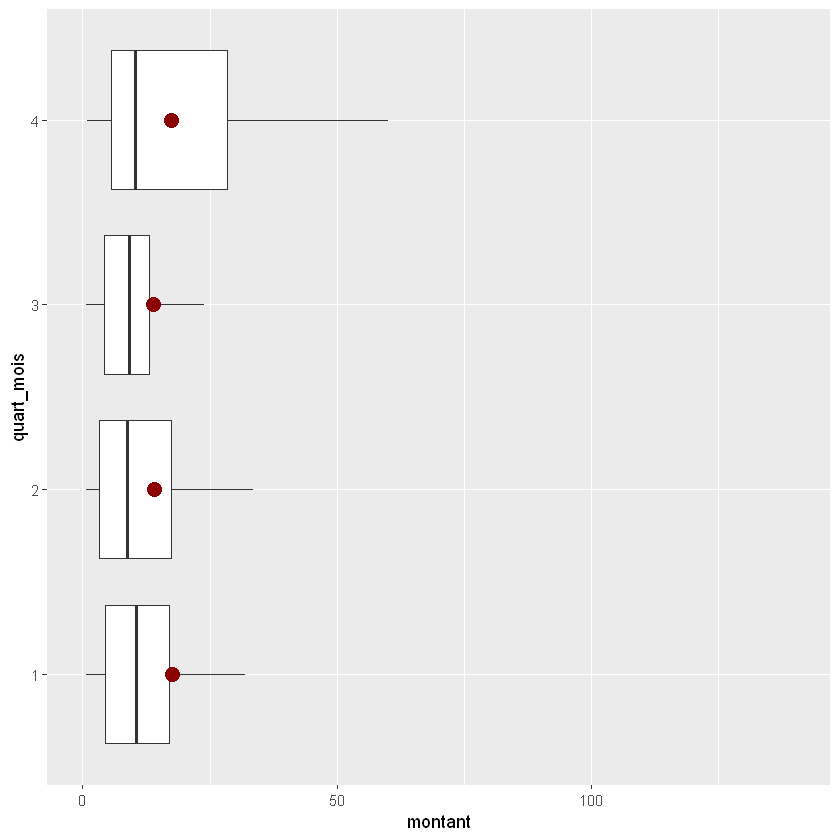

In [50]:
X = "quart_mois" # qualitative
Y = "montant" # quantitative

sous_echantillon$quart_mois = as.factor(sous_echantillon$quart_mois)

ggplot(sous_echantillon, aes(x=quart_mois, y=montant)) + 
    geom_boxplot(outlier.shape = NA) + coord_flip() + 
    stat_summary(fun.y=mean, colour="darkred", geom="point", shape=19, size=4) +
    scale_y_continuous(limits = c(0,140))

eta_squared(sous_echantillon[,X],sous_echantillon[,Y])

# <a name="C12"> P4C6 - Analysez deux variables qualitatives avec le Chi-2</a>

Pour répondre à ces questions, vous pouvez afficher le tableau de contingence comme ceci :

In [51]:
X = "quart_mois"
Y = "categ"

c = as.data.frame.matrix(table(data[,c(X,Y)]))
cont = c

tx = rowSums(cont)
ty = colSums(cont)

cont[,"total"] = tx
cont["total",(1:(ncol(cont)-1))] = ty
cont["total","total"] = nrow(data)
cont

,AUTRE,COTISATION BANCAIRE,COURSES,FACTURE TELEPHONE,LOYER,RESTAURANT,TRANSPORT,total
1,55,7,6,6,0,3,9,86
2,45,0,11,1,6,7,6,76
3,60,0,7,0,0,4,4,75
4,52,0,15,0,0,2,2,71
total,212,7,39,7,6,16,21,308


Voici le code affichant cette heatmap :

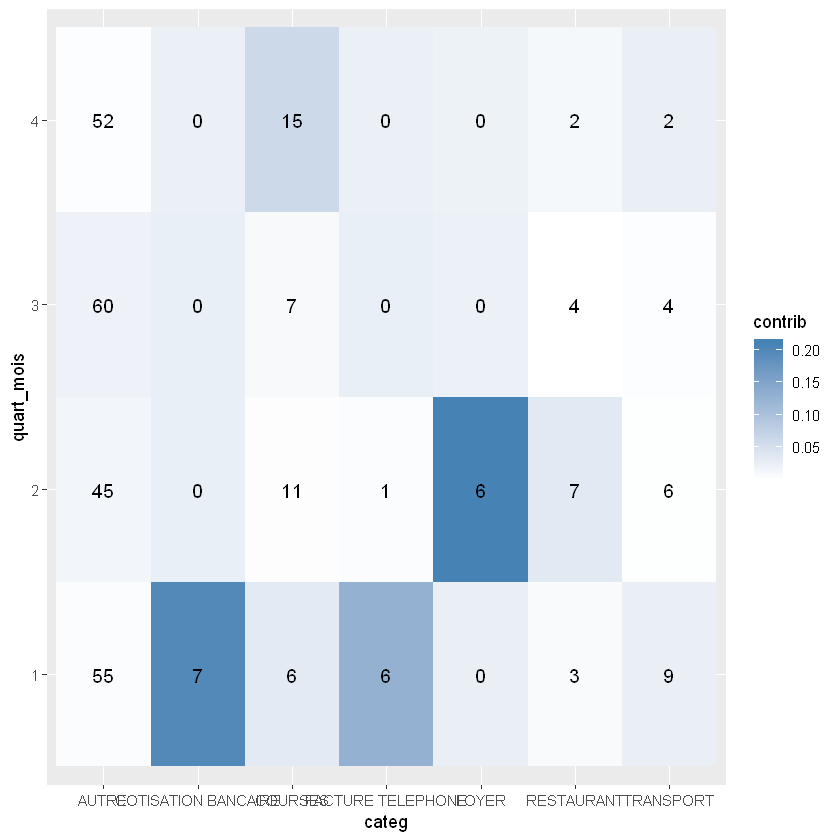

In [52]:
indep = tx %*% t(ty) / nrow(data)

mesure = (c-indep)^2/indep
xi_n = sum(mesure)

contributions = mesure/xi_n

cont_reshaped = as.data.frame(table(data[,c(X,Y)]))
cont_reshaped["contrib"] = NA
for(i in 1:nrow(cont_reshaped)){
    x = cont_reshaped[i,X]
    y = cont_reshaped[i,Y]
    cont_reshaped[i,"contrib"] = contributions[x,y]
}
ggplot(cont_reshaped, aes_string(X,Y)) +    
    geom_tile(aes(fill = contrib)) +
    geom_text(aes(label=Freq), size=4) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    coord_flip()